In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
from pathlib import Path

import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
from MDAnalysis.analysis import msd, rms
from mycolorpy import colorlist as mcp
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
from base import Mols,RD_MOLECULES
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)
plt.rcParams["figure.figsize"] = (10, 7)

# Traj analyse

In [3]:
%matplotlib inline

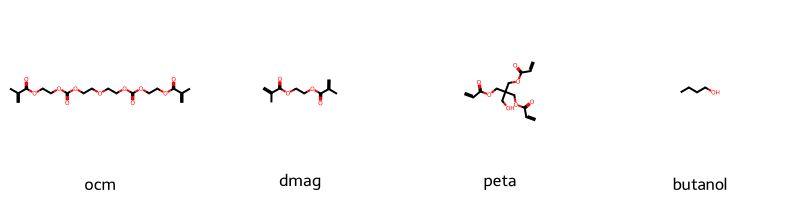

In [4]:
Draw.MolsToGridImage(
    list(RD_MOLECULES.values()),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in RD_MOLECULES.keys()],
)

In [5]:
# D cm2/day
def get_solve_dir(work_dir: str):
    result_dir = Path(work_dir)
    for system_sir in os.listdir(result_dir):
        for T_dir in os.listdir(result_dir / system_sir):
            yield result_dir / system_sir / T_dir


def get_MSD(u, compound: Mols):
    residue = compound.value
    selection = f'resname {residue}'
    m = msd.EinsteinMSD(u, select=selection)
    m.run()

    time = m.times * 1e-12  # ps -> s
    MSD = np.mean(m.results['msds_by_particle'], axis=1) * 1e-16  # A2 -> cm2
    return pd.DataFrame({'Time': time, residue: MSD}).fillna(0)


def get_RMSD(u, compound: Mols):
    residue = compound.value
    selection = f'resname {residue}'
    m = rms.RMSD(u, u, selection)
    m.run()
    return pd.DataFrame(m.results.rmsd[:, 1:], columns=['Time', residue])


def regress(data: pd.DataFrame):
    time, MSD = data.iloc[:, 0], data.iloc[:, 1]
    regression = linregress(time, MSD)
    D0 = regression.intercept
    D = regression.slope
    return D, D0


def strict(df: pd.DataFrame):
    slopes = []
    for i in np.arange(0, 200, 20):
        slopes.append((df.iloc[i, 0], regress(df.loc[i : i + 20])[0], i))
    slopes = np.array(slopes)

    need_slopes = slopes[(slopes[:, 1] - slopes[:, 1].mean()) / (slopes[:, 1].mean()+1e-9) < 0.2]
    # return need_slopes
    i0, i1 = need_slopes[0][2], need_slopes[-1][2]

    return df.loc[i0:i1]

In [154]:
directory = Path('tests/4MD')
compound =Mols.butanol
T = 25
pdb = Path(r'gromacs\workspace\solvs\butanol_100_700\30\box.gro')
traj = Path(r'gromacs\workspace\solvs\butanol_100_700\30\traj.xtc')

100%|██████████| 3000/3000 [00:00<00:00, 4784.67it/s]


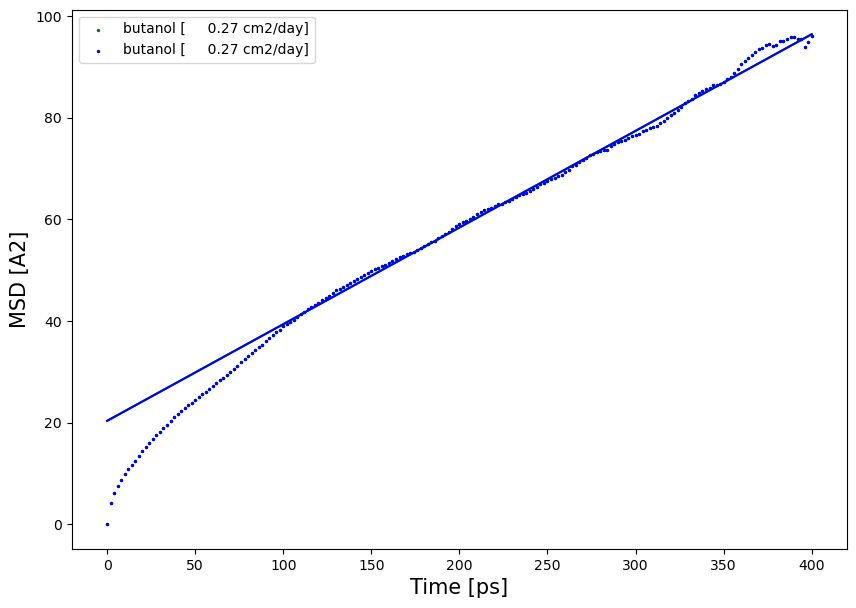

In [155]:
u = mda.Universe(pdb, traj)

x_scaller, y_scaller = 1e12,1e16
df = get_MSD(u, compound)
S, S0 = regress(strict(df))
D = S / 6 * 24 * 60 * 60


df_but = get_MSD(u, Mols.butanol)
S_but, S0_but = regress(strict(df_but))
D_but = S_but / 6 * 24 * 60 * 60


# df = strict(get_RMSD(u, compound))
# S, S0 = 0, df.iloc[:, 1].median()
# D = S0**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60

# df_but = strict(get_RMSD(u, 'butanol'))
# S_but, S0_but = 0, df_but.iloc[:, 1].median()
# D_but = S0_but**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60

fig, ax = plt.subplots()
ax.set_ylabel('MSD [A2]')
ax.set_xlabel('Time [ps]')

time = df['Time']

ax.scatter(
    time * x_scaller,
    df.iloc[:, 1] * y_scaller,
    label=f'{compound.name:7} [{D: 9.2f} cm2/day]',
    c='g',
    s=2,
)

time_but = df_but['Time']
ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
ax.scatter(
    time_but * x_scaller,
    df_but.iloc[:, 1] * y_scaller,
    label=f'butanol [{D_but: 9.2f} cm2/day]',
    c='b',
    s=2,
)
ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
ax.legend()

# ax.set_title(f"{compound} - {x} butanol :{T} C")
# fig.savefig(f"MSD_old.jpg", dpi=600)

In [6]:
solves_path =r'gromacs\workspace\solvs'
plots_path = r'gromacs\workspace\MSD_plots2'

pdb_name ='box.gro'
traj_name= '5MD/md.xtc'


# solves_path =r'openmm\workspace\results'
# plots_path = r'openmm\workspace\MSD_plots2'

# pdb_name ='Eq.pdb'
# traj_name= 'traj.xtc'

100%|██████████| 5600/5600 [00:01<00:00, 5273.21it/s]
0it [00:00, ?it/s]
100%|██████████| 5600/5600 [00:01<00:00, 5126.96it/s]
0it [00:00, ?it/s]
100%|██████████| 5600/5600 [00:01<00:00, 5467.80it/s]
0it [00:00, ?it/s]
100%|██████████| 5600/5600 [00:01<00:00, 5190.43it/s]
0it [00:00, ?it/s]
100%|██████████| 11000/11000 [00:02<00:00, 5215.73it/s]
0it [00:00, ?it/s]
100%|██████████| 11000/11000 [00:02<00:00, 4720.84it/s]
0it [00:00, ?it/s]
100%|██████████| 11000/11000 [00:02<00:00, 4871.11it/s]
0it [00:00, ?it/s]
100%|██████████| 11000/11000 [00:02<00:00, 5108.88it/s]
0it [00:00, ?it/s]
100%|██████████| 7800/7800 [00:01<00:00, 4642.60it/s]
0it [00:00, ?it/s]
100%|██████████| 7800/7800 [00:01<00:00, 4983.09it/s]
0it [00:00, ?it/s]
100%|██████████| 7800/7800 [00:01<00:00, 4698.75it/s]
0it [00:00, ?it/s]
100%|██████████| 7800/7800 [00:01<00:00, 4396.94it/s]
0it [00:00, ?it/s]
100%|██████████| 1470/1470 [00:00<00:00, 4136.89it/s]


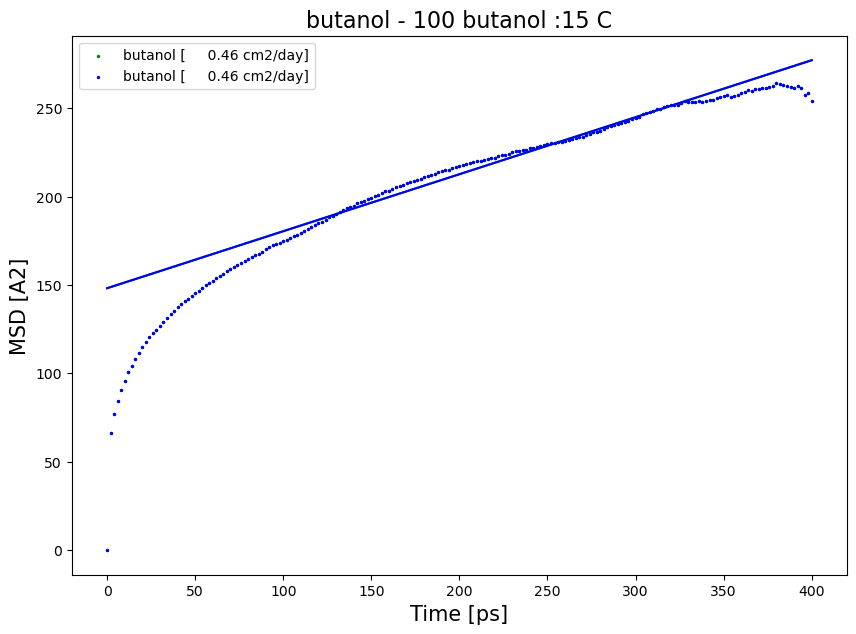

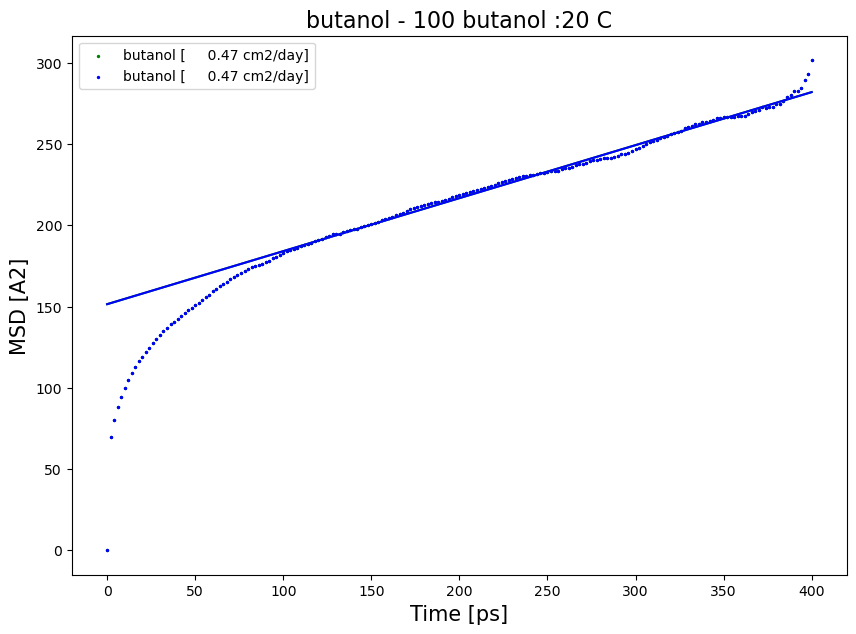

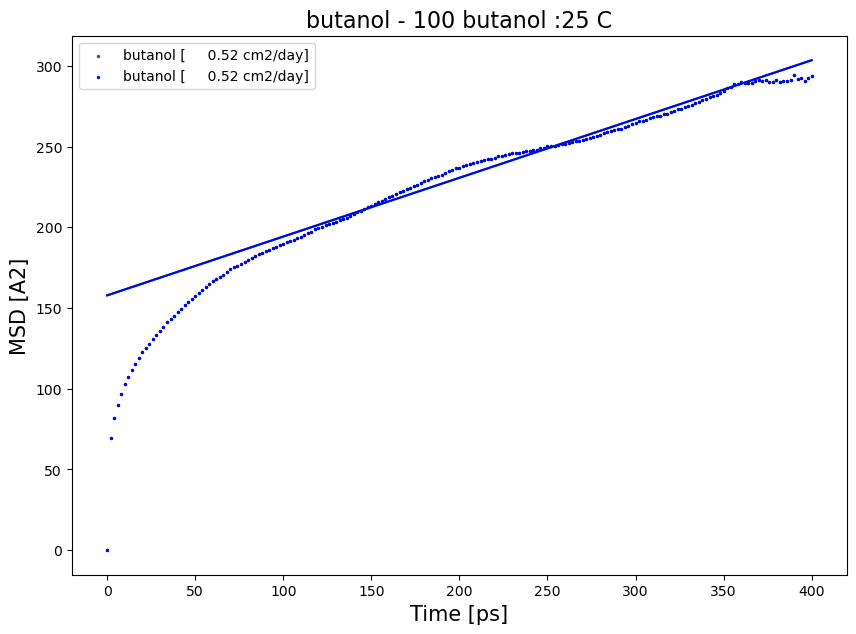

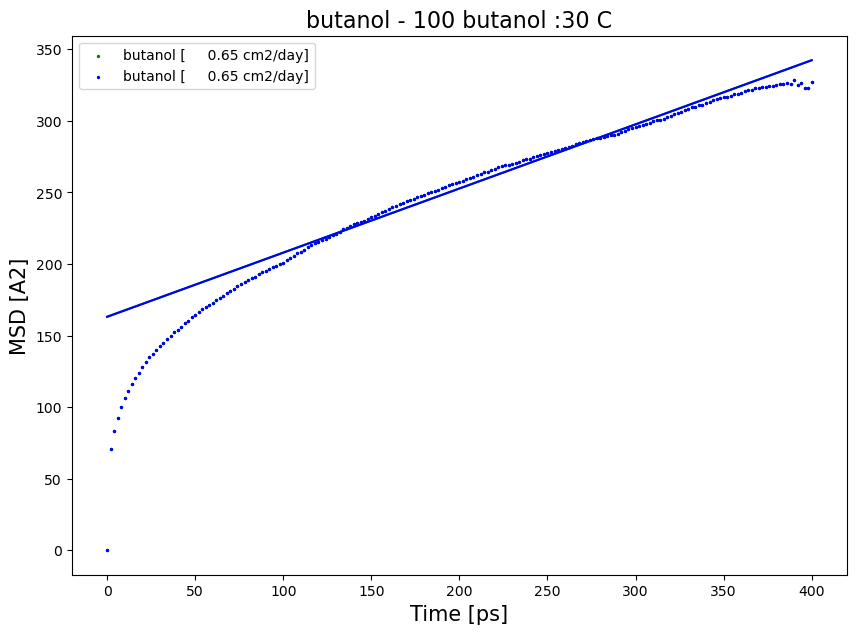

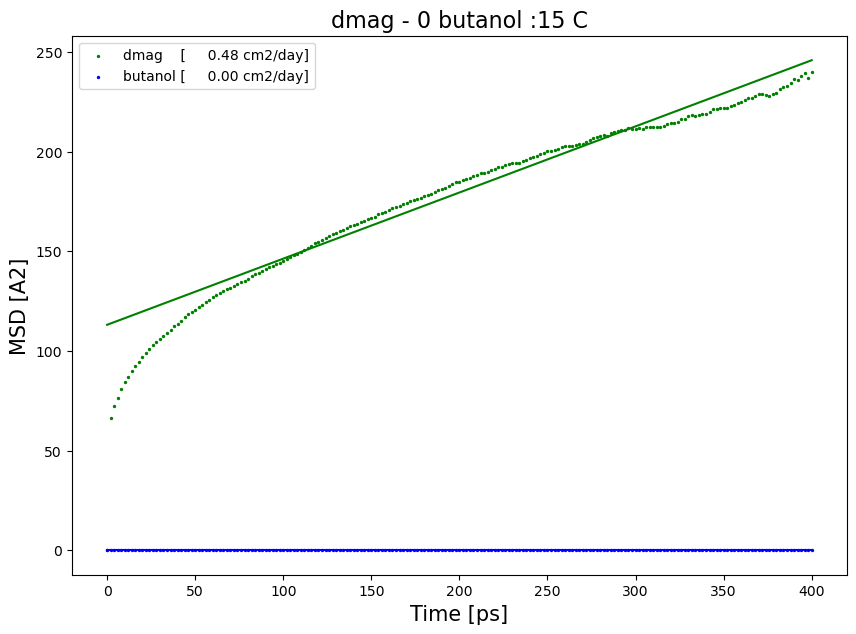

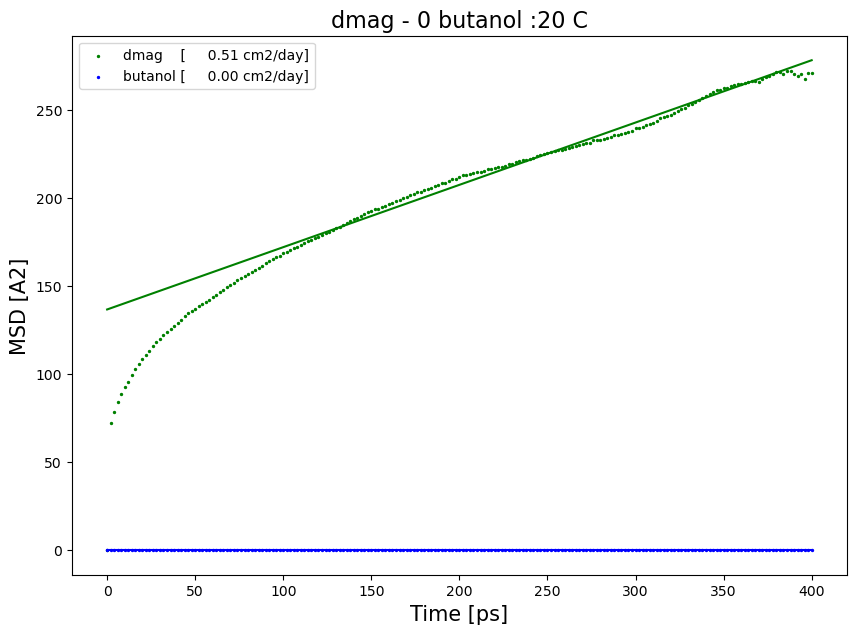

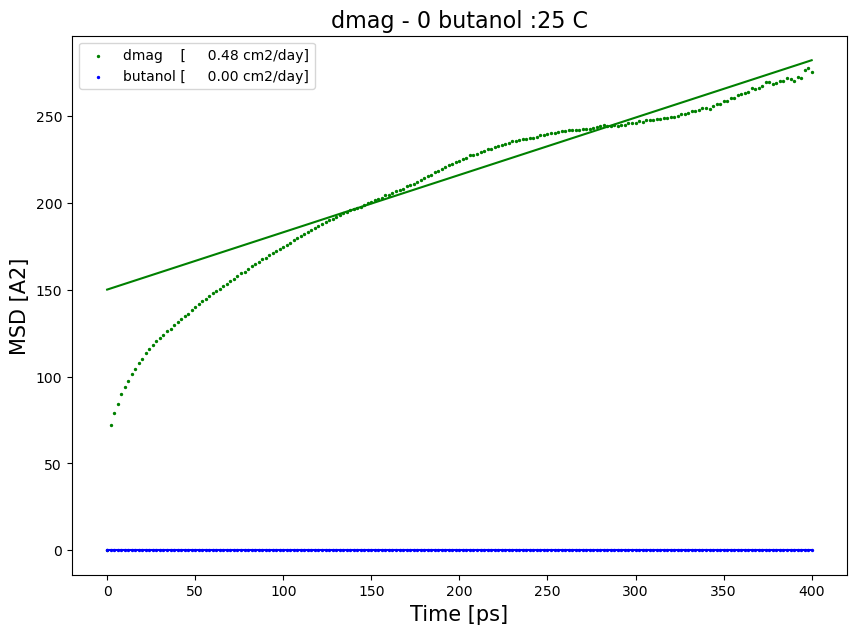

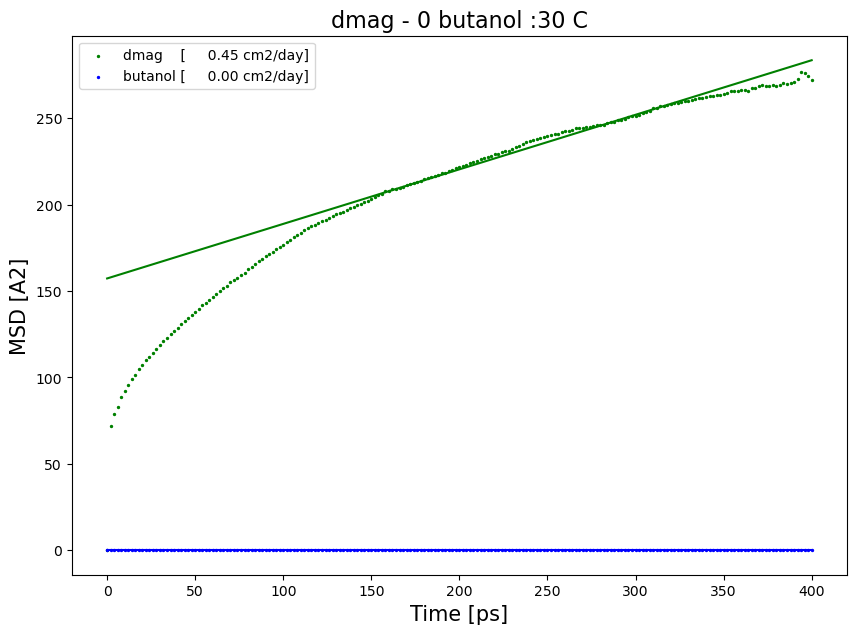

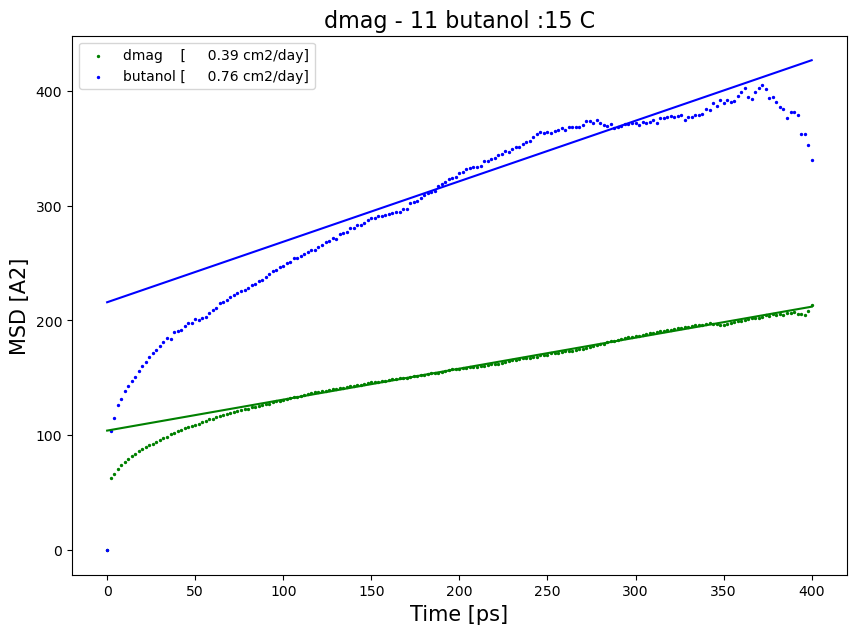

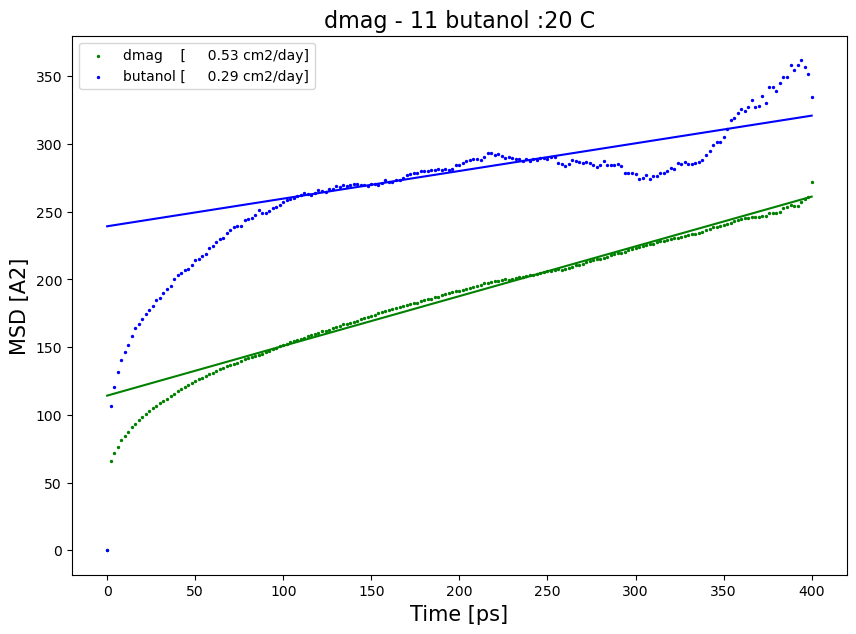

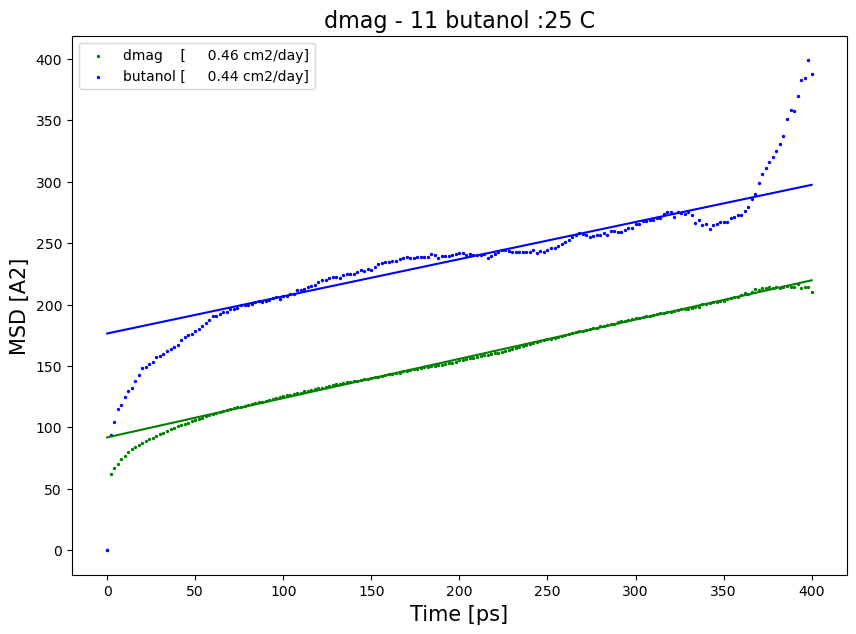

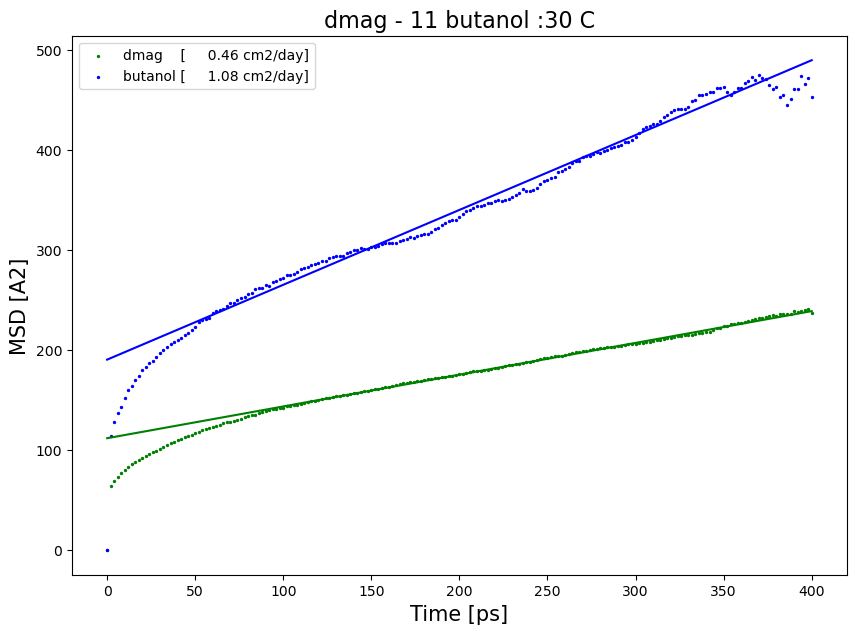

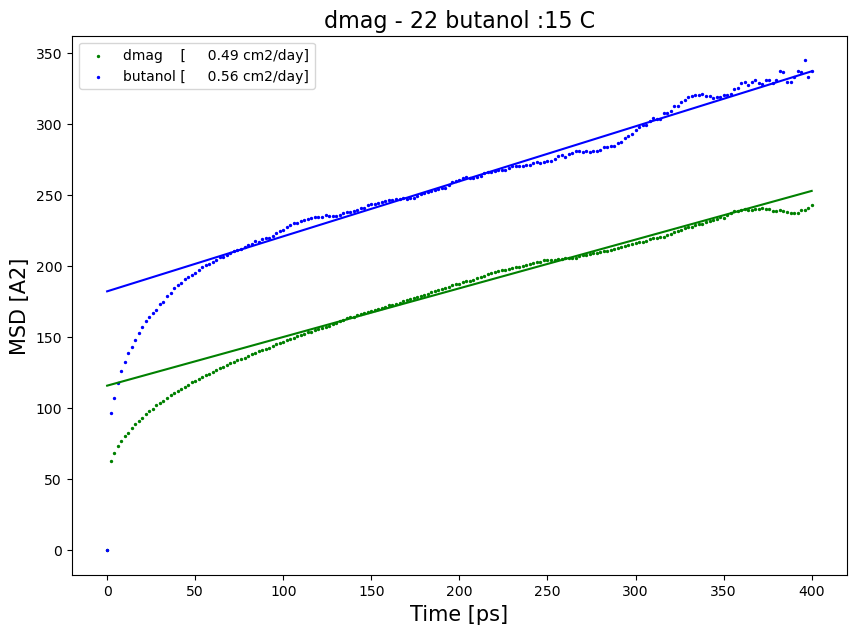

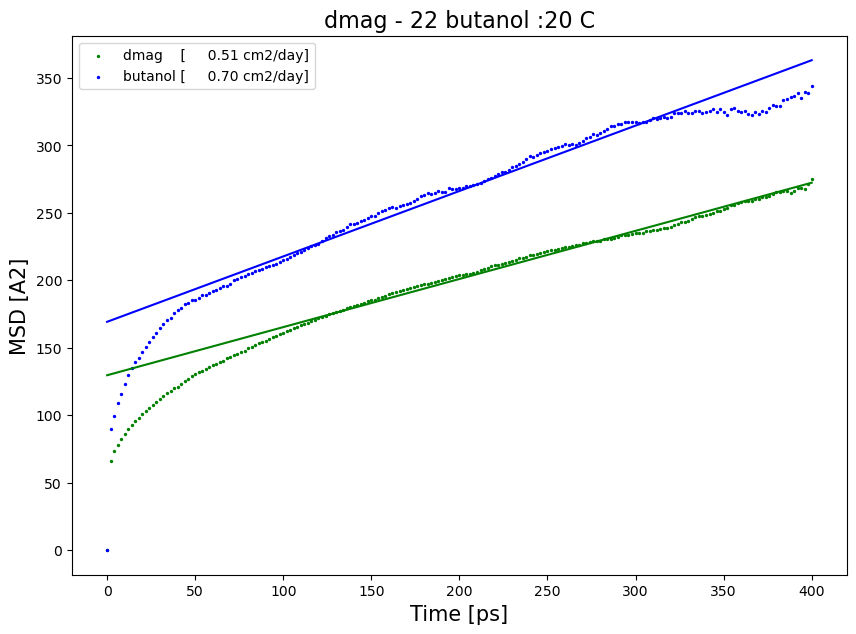

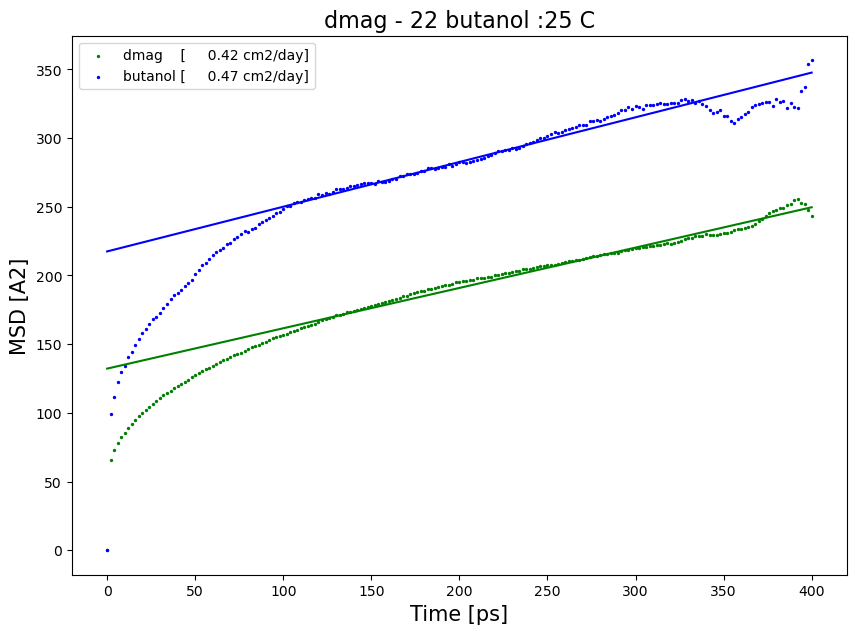

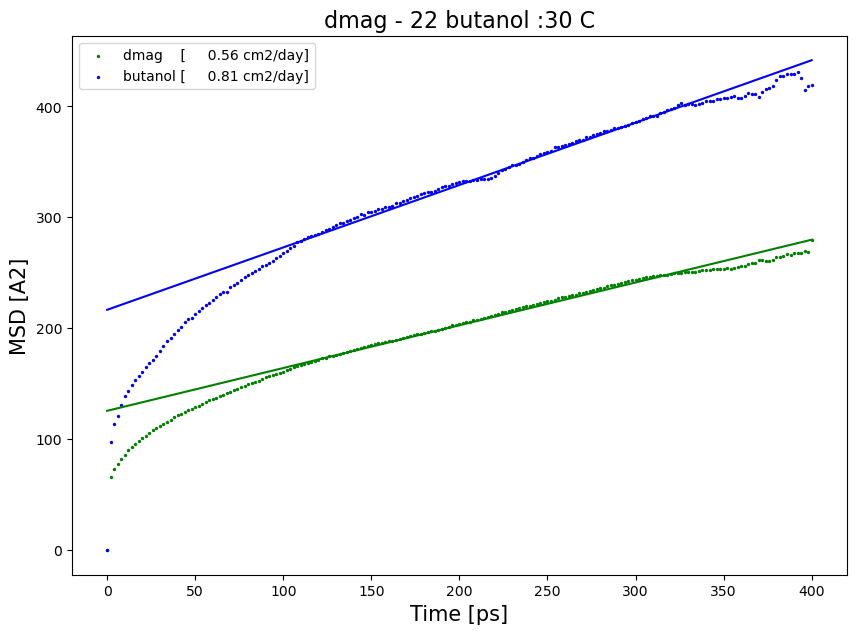

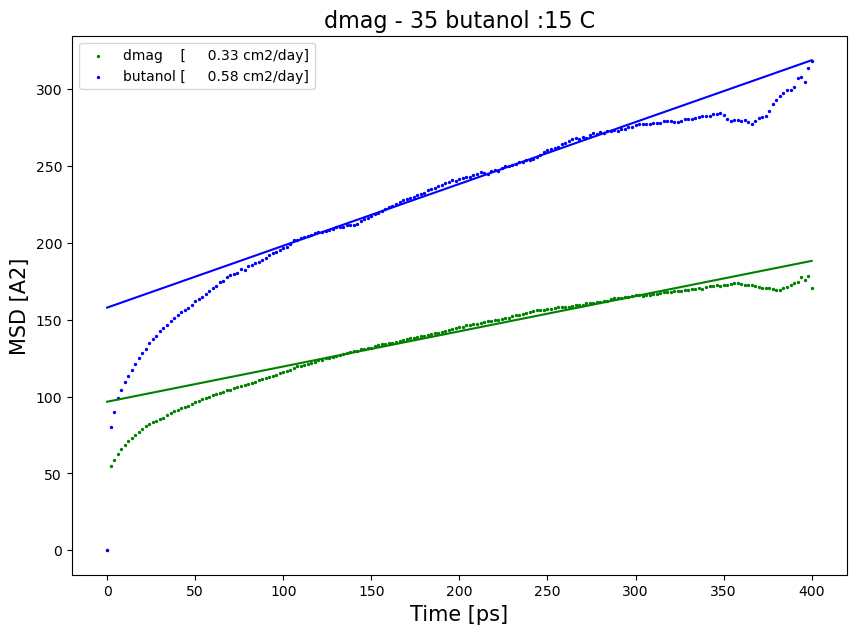

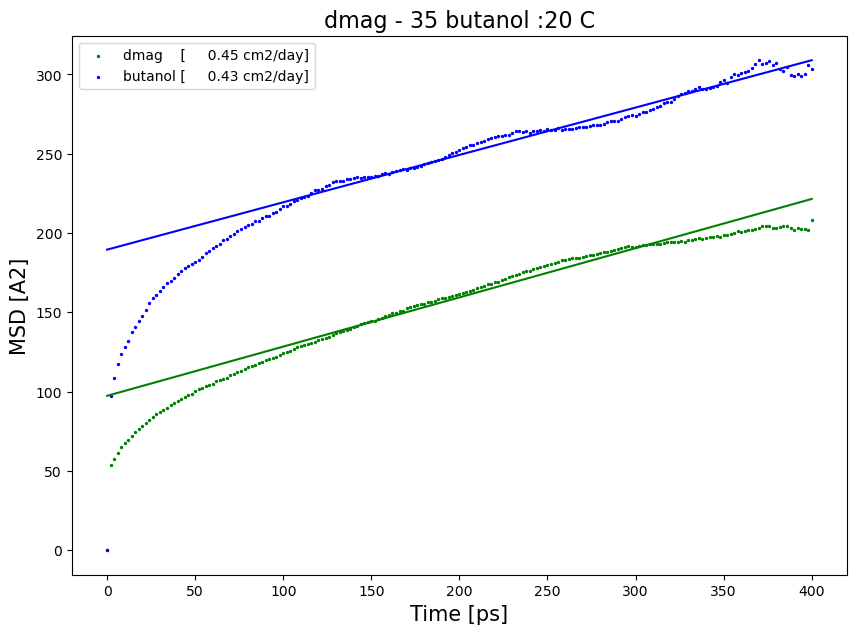

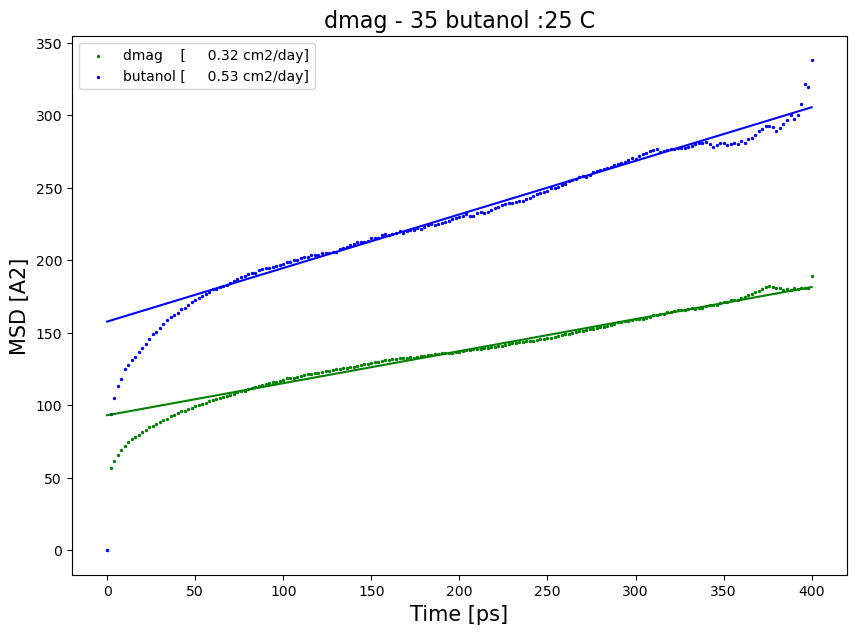

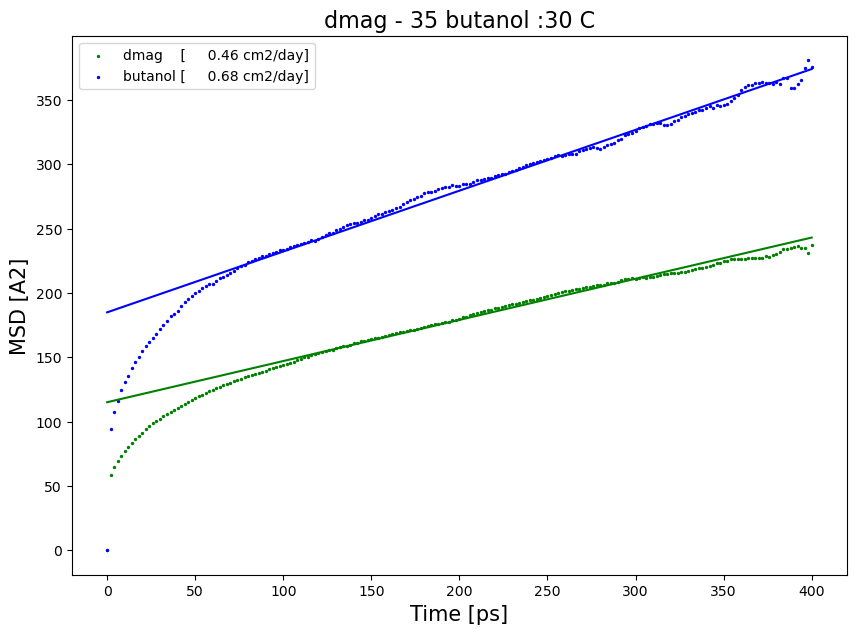

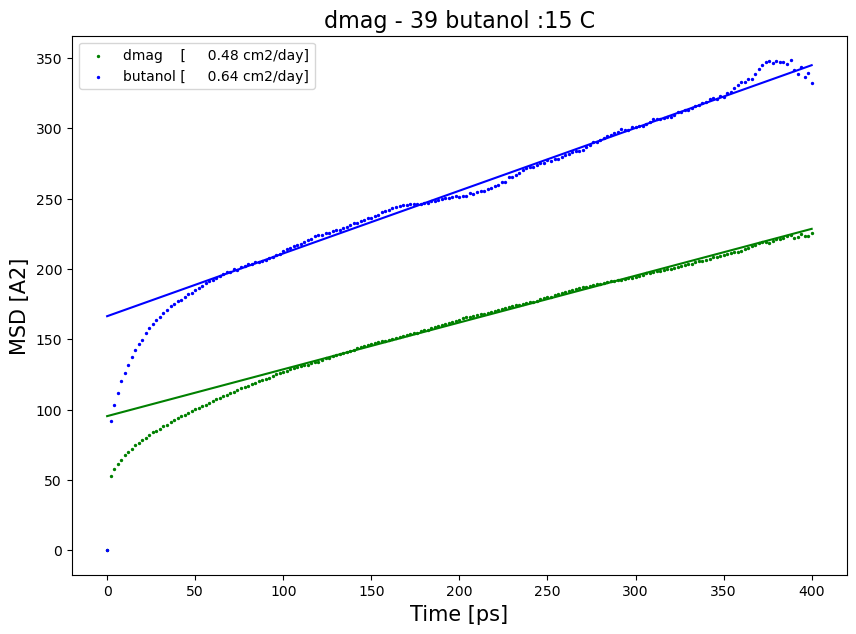

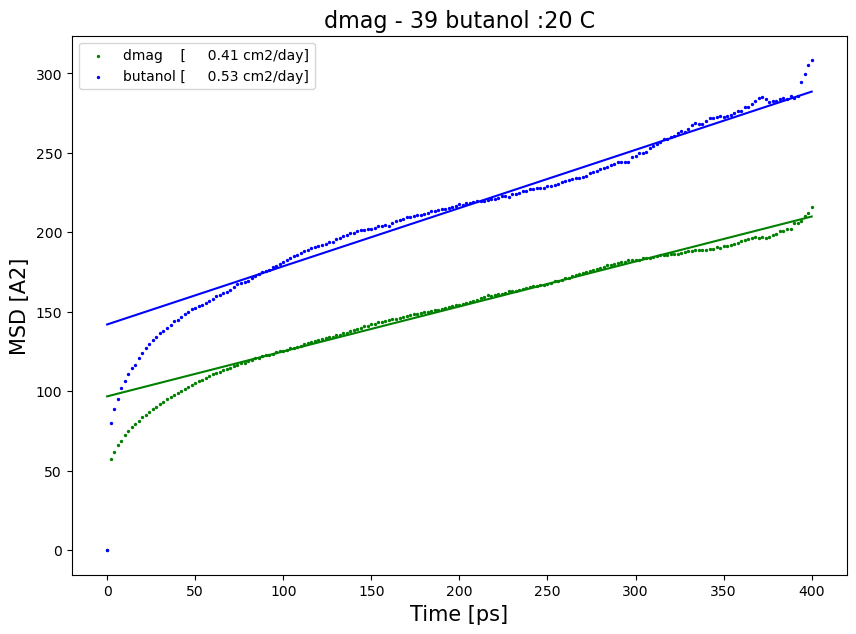

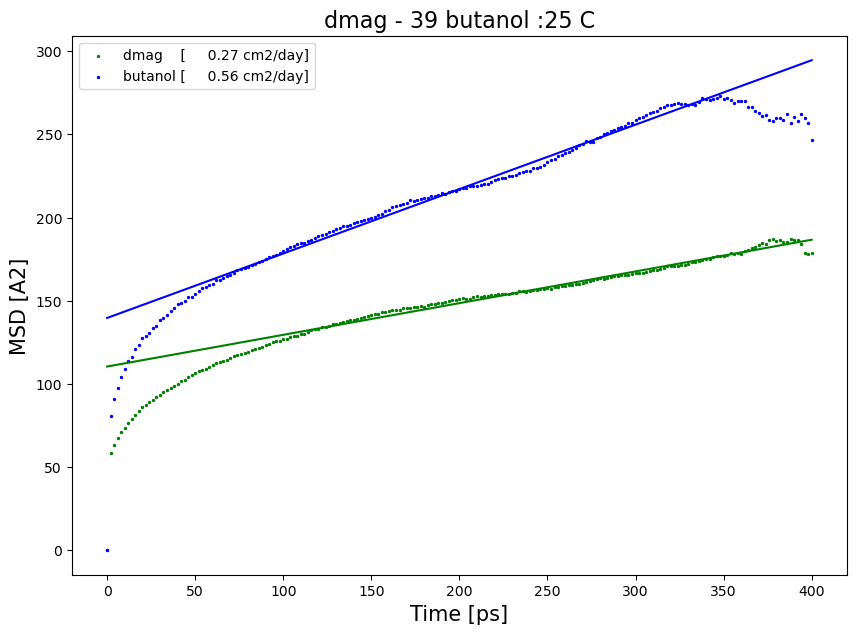

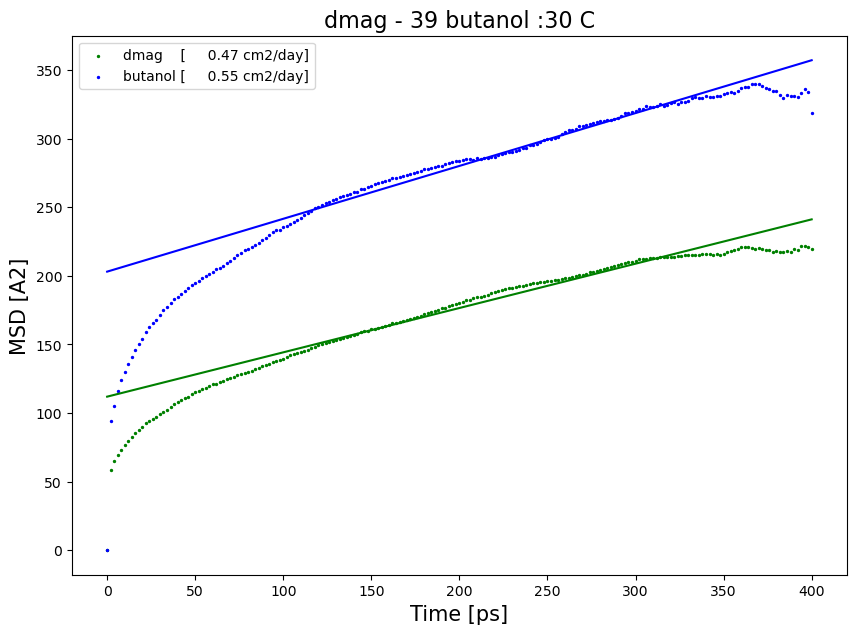

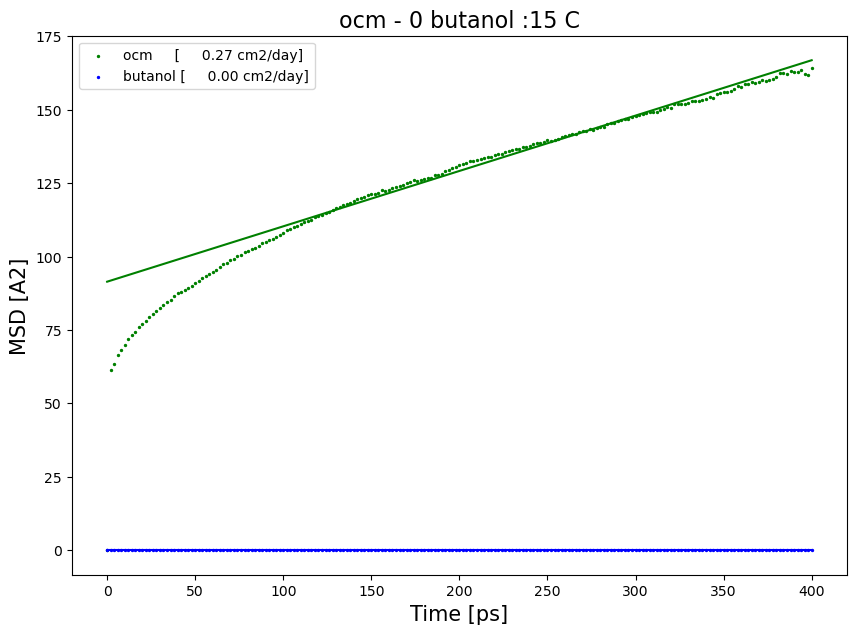

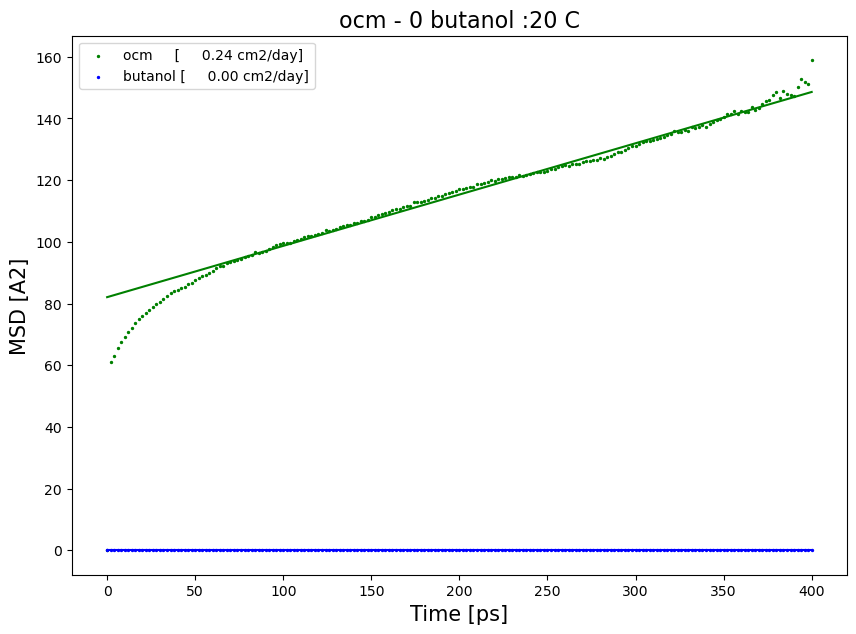

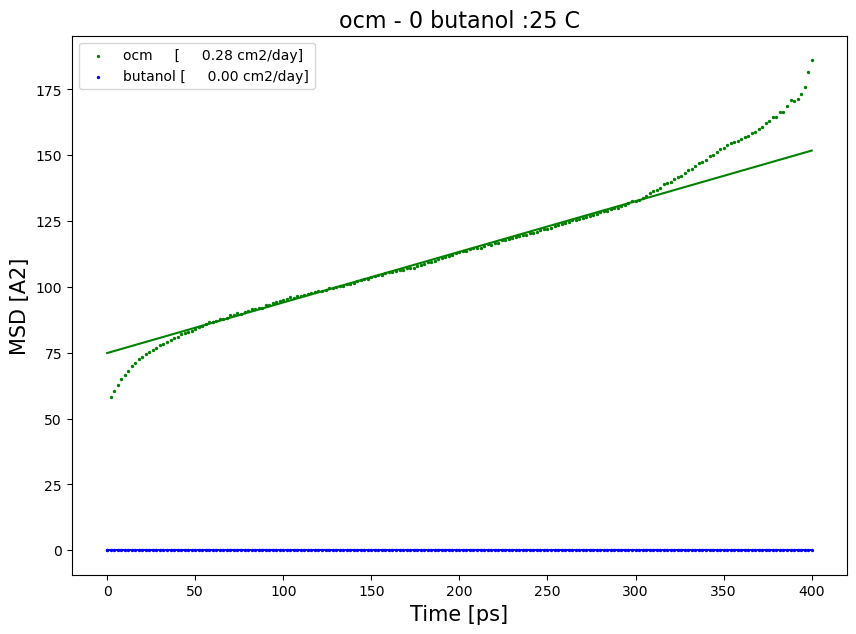

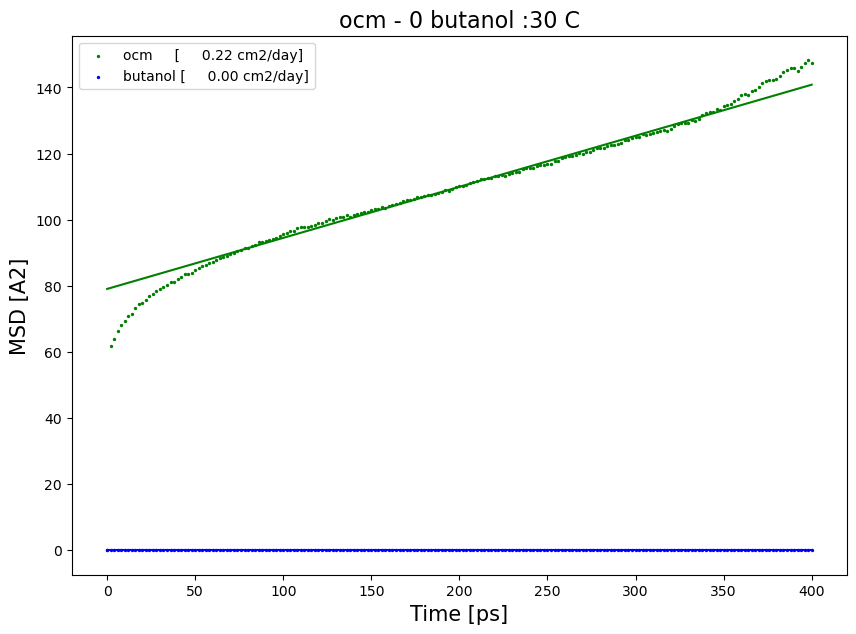

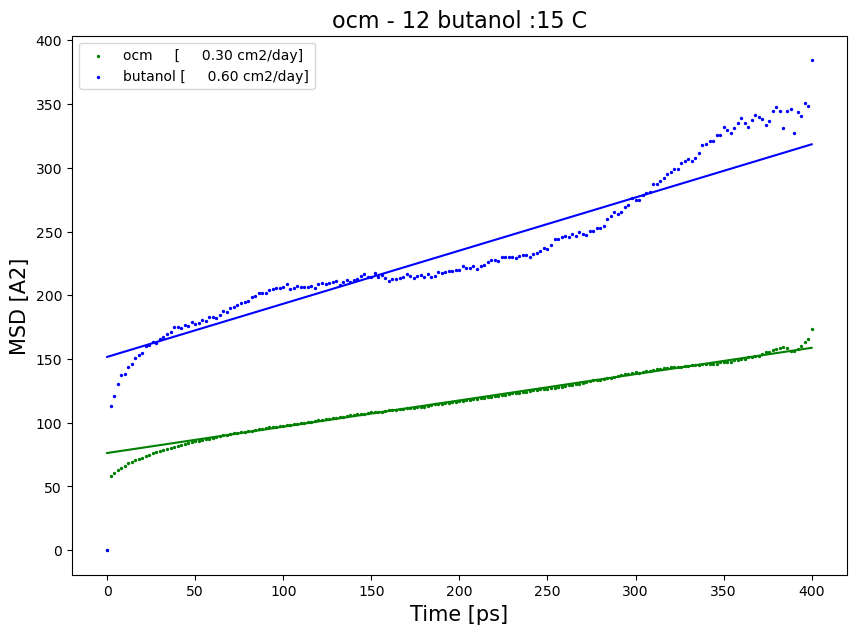

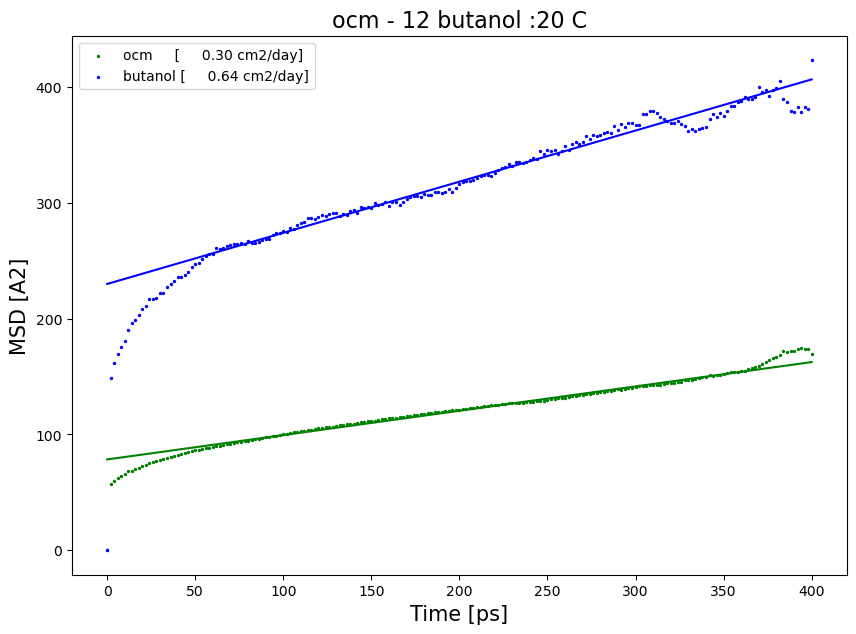

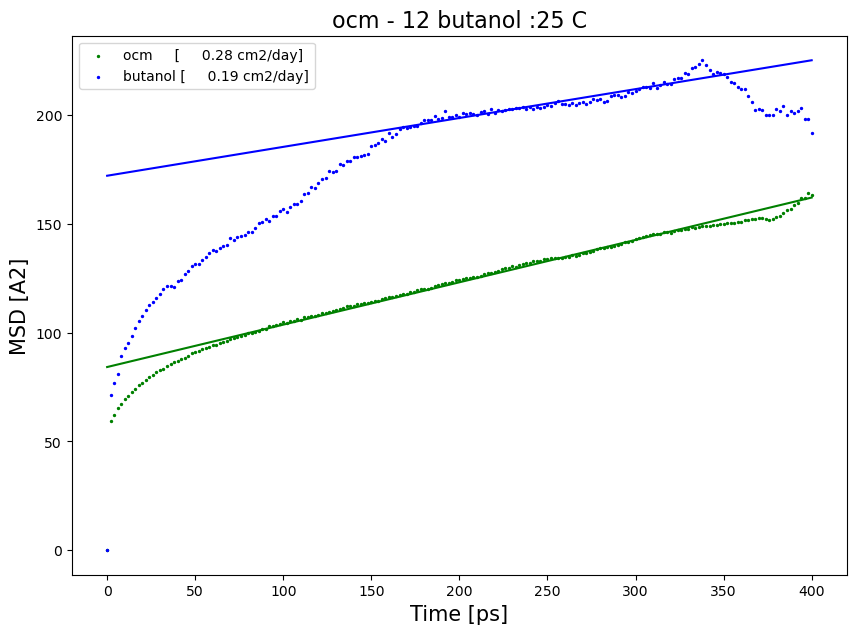

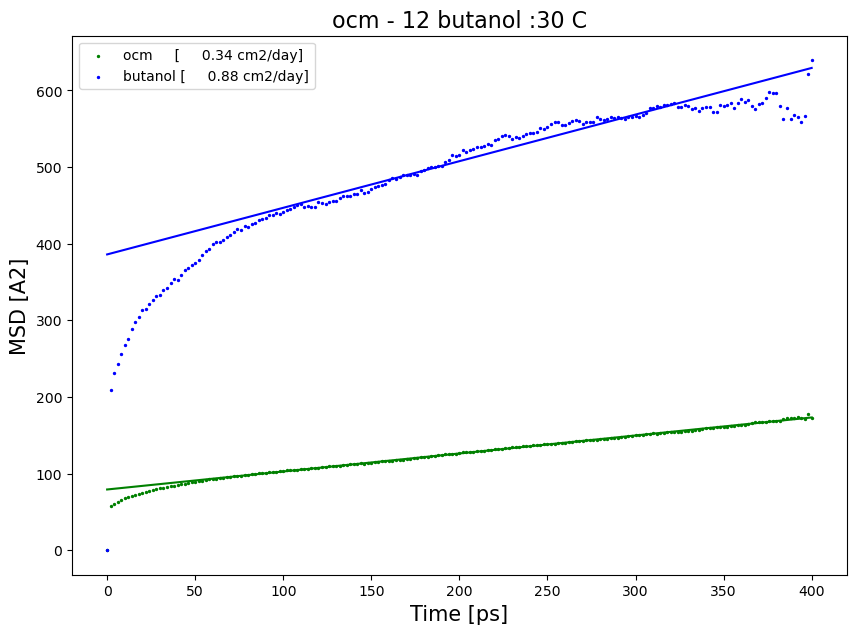

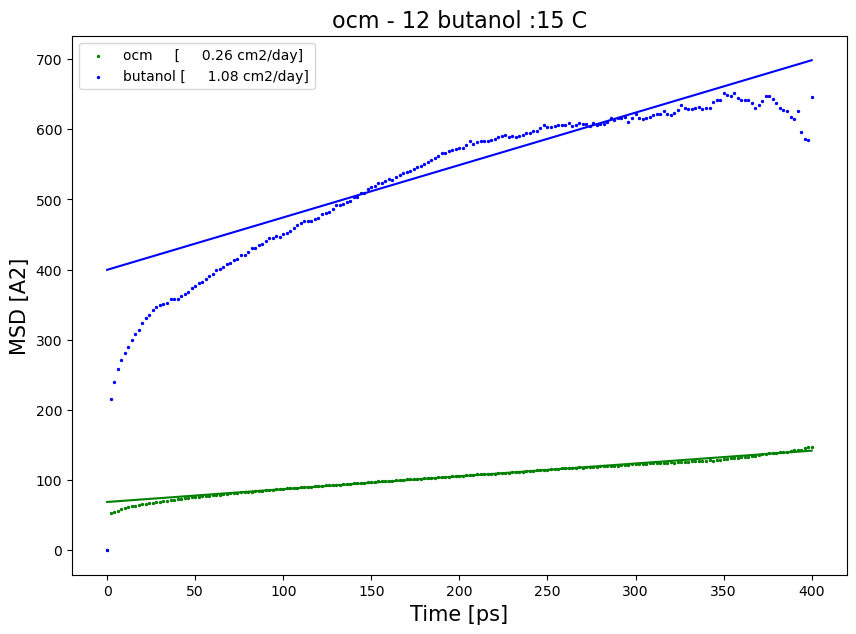

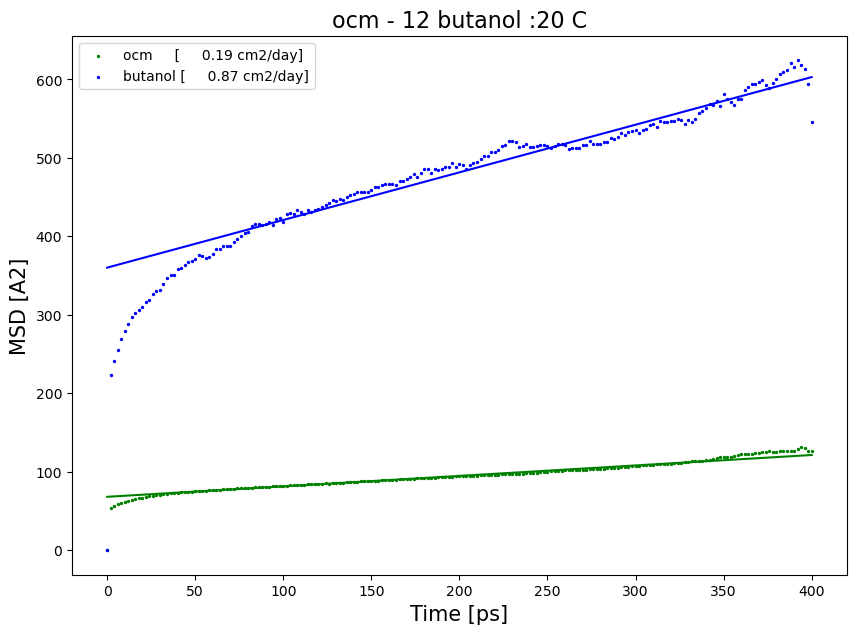

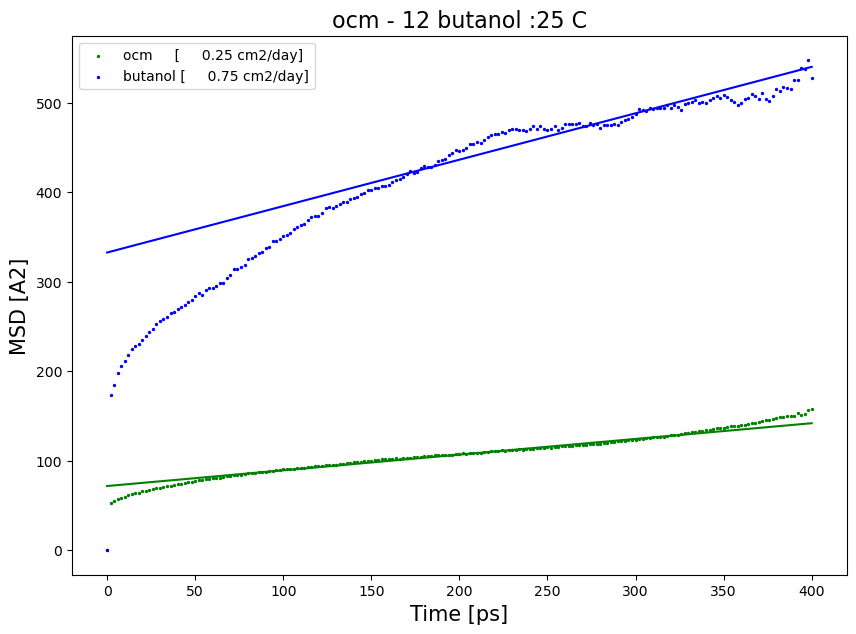

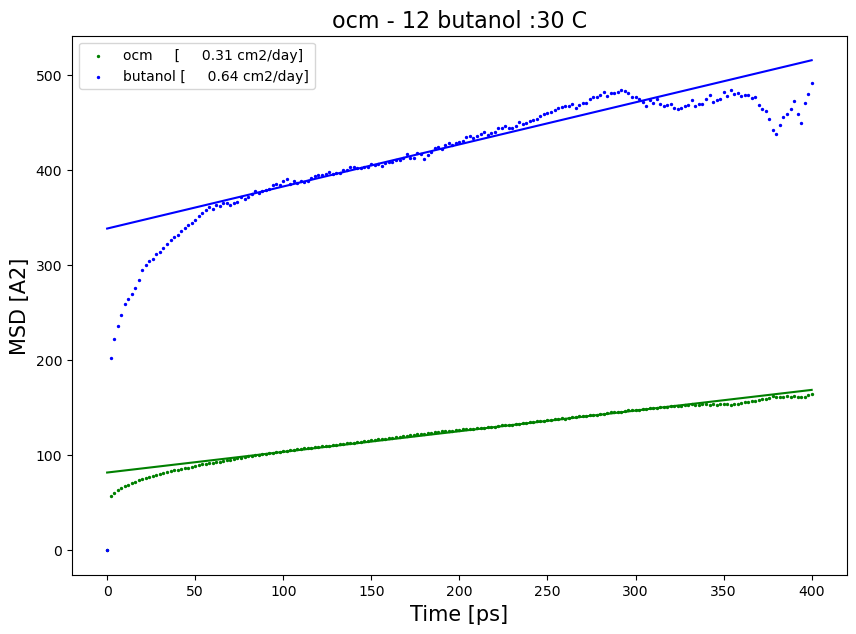

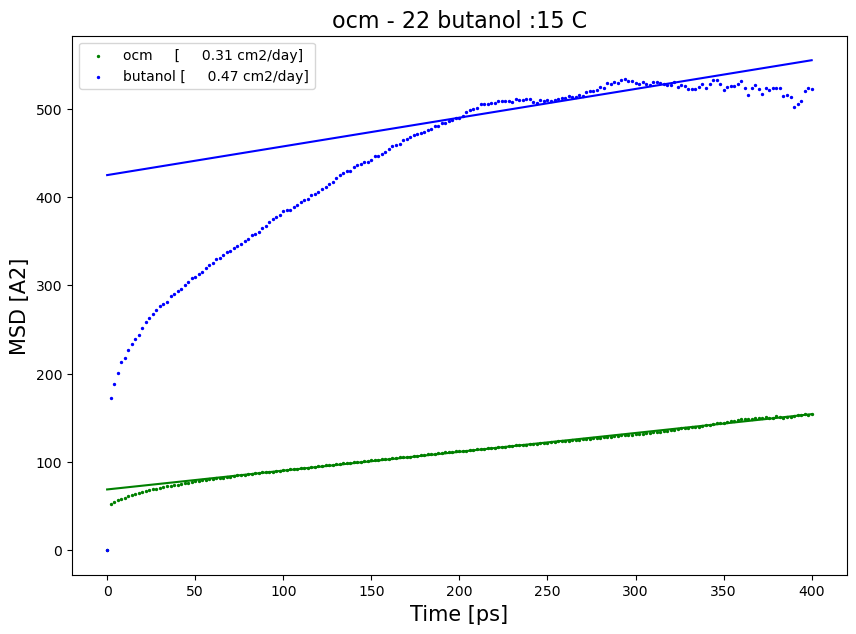

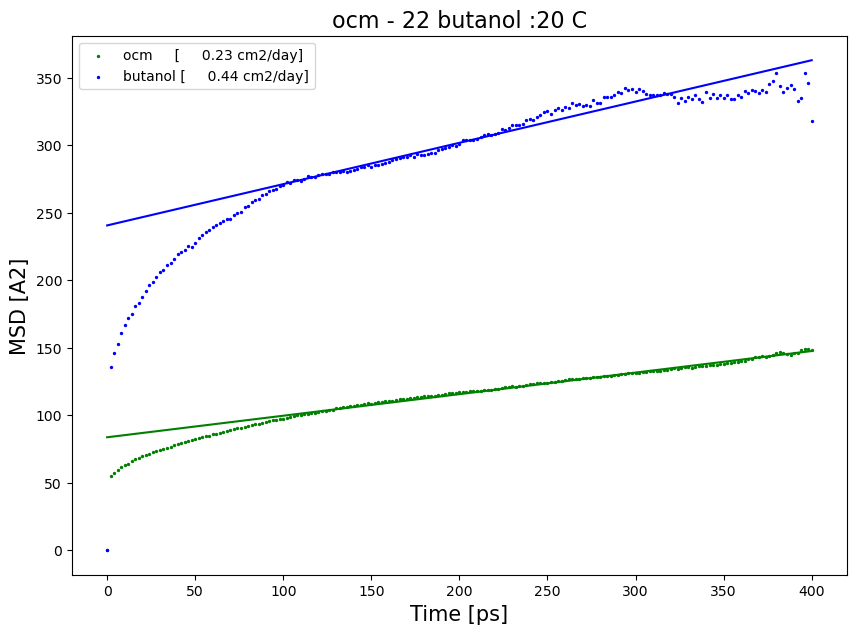

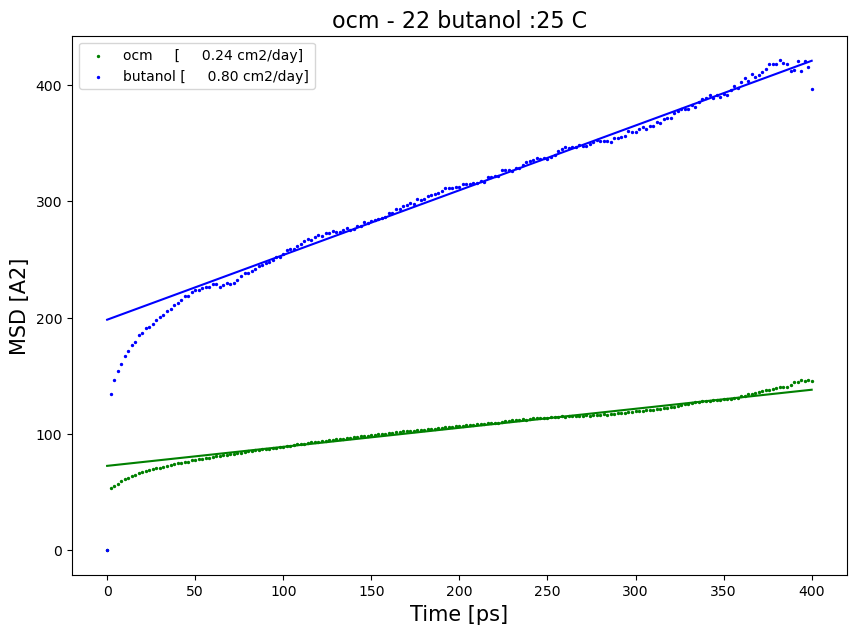

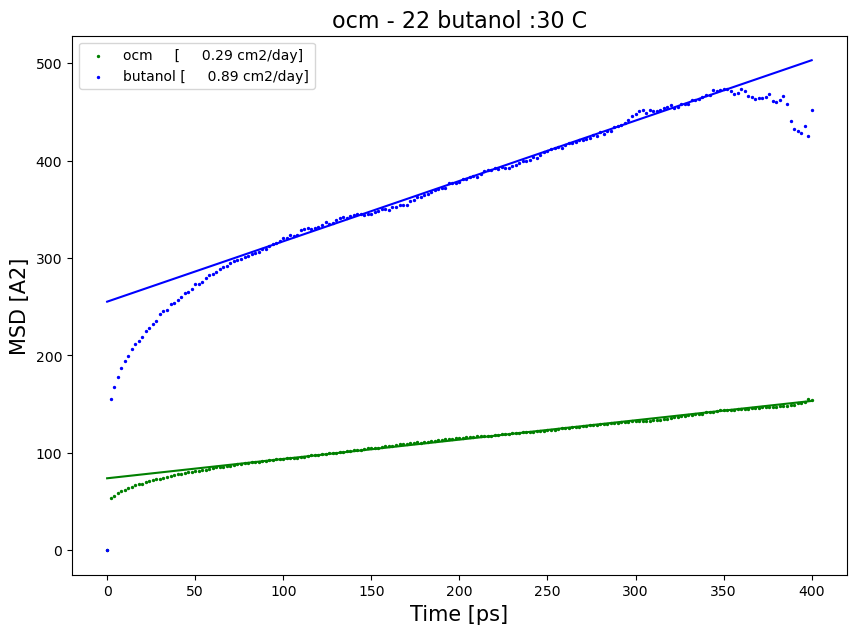

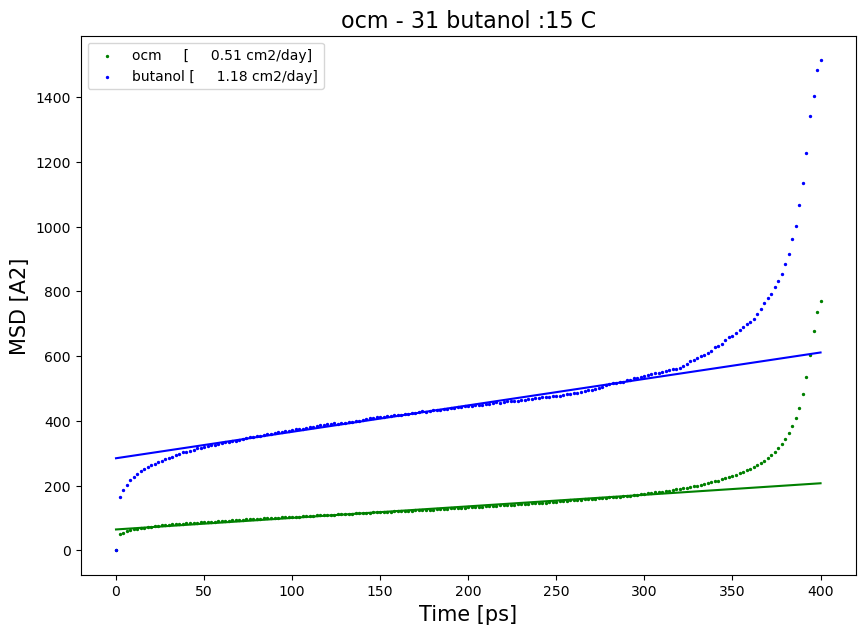

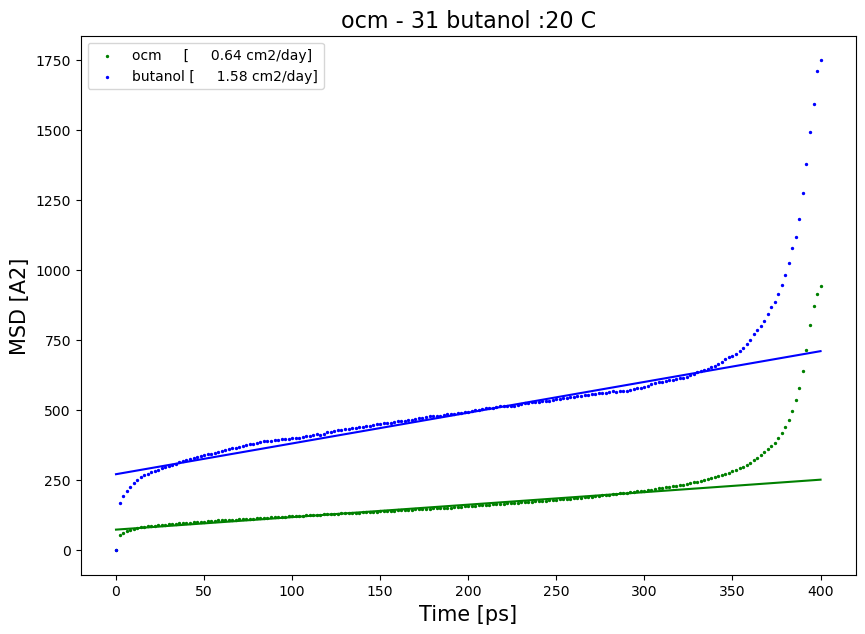

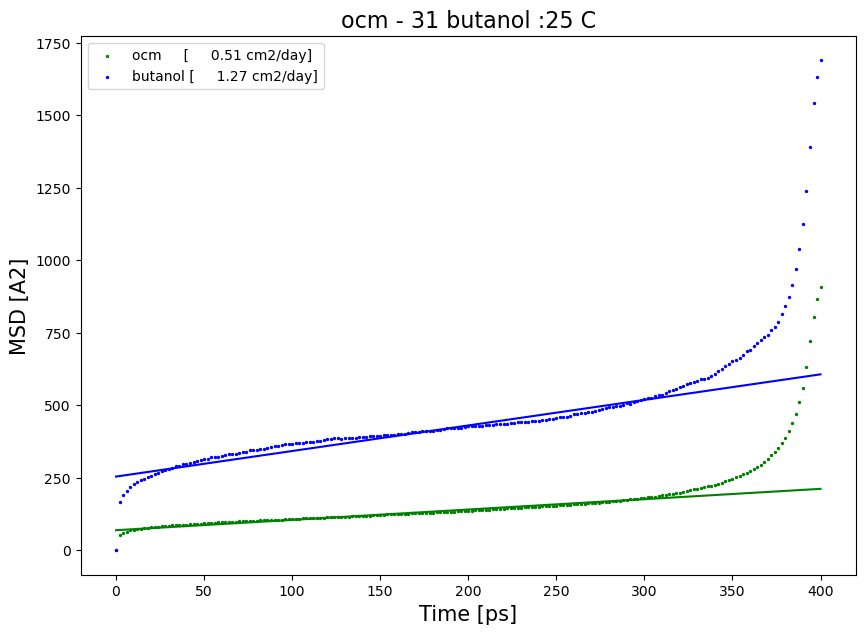

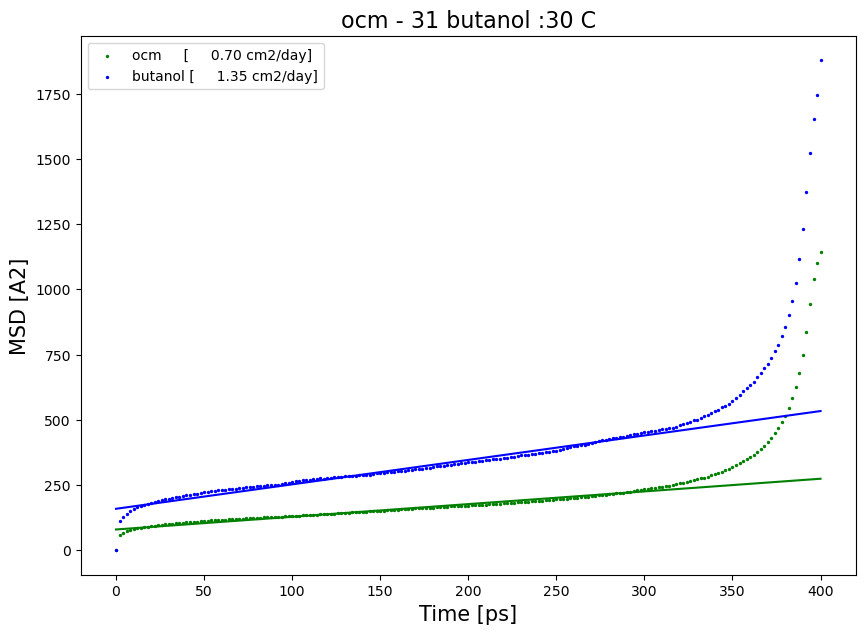

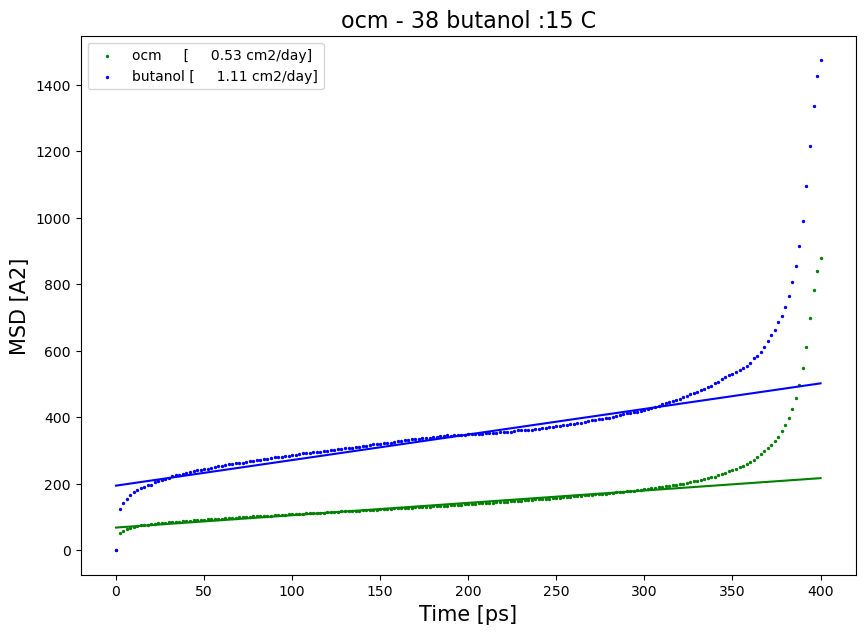

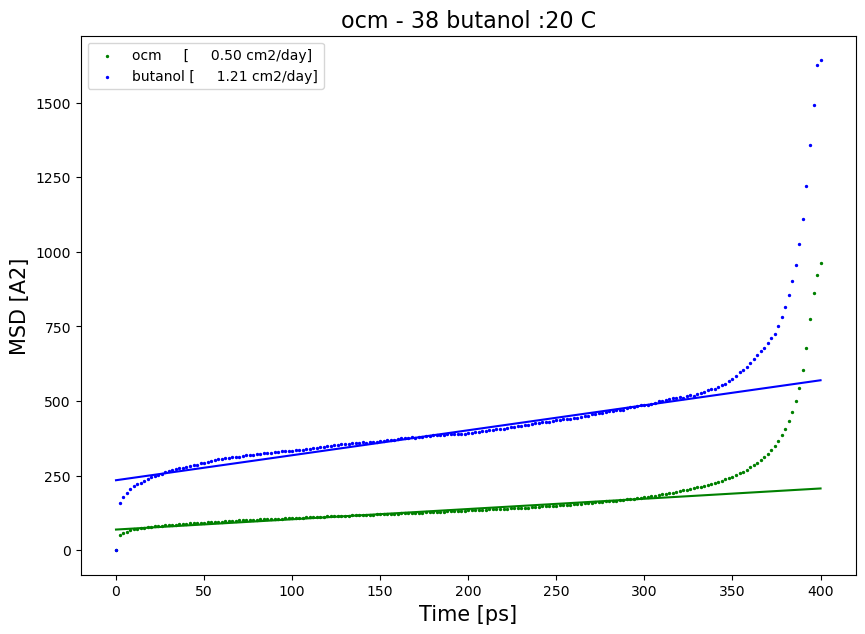

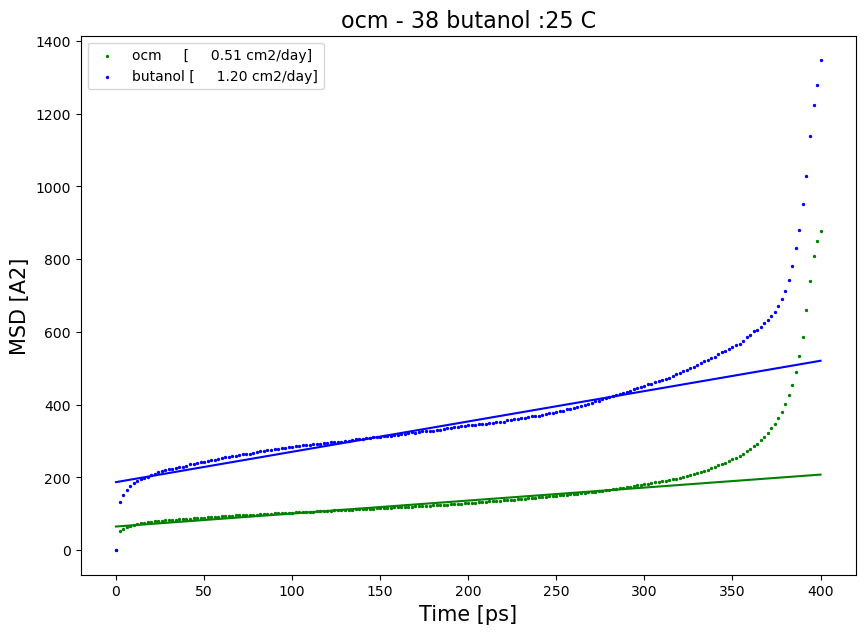

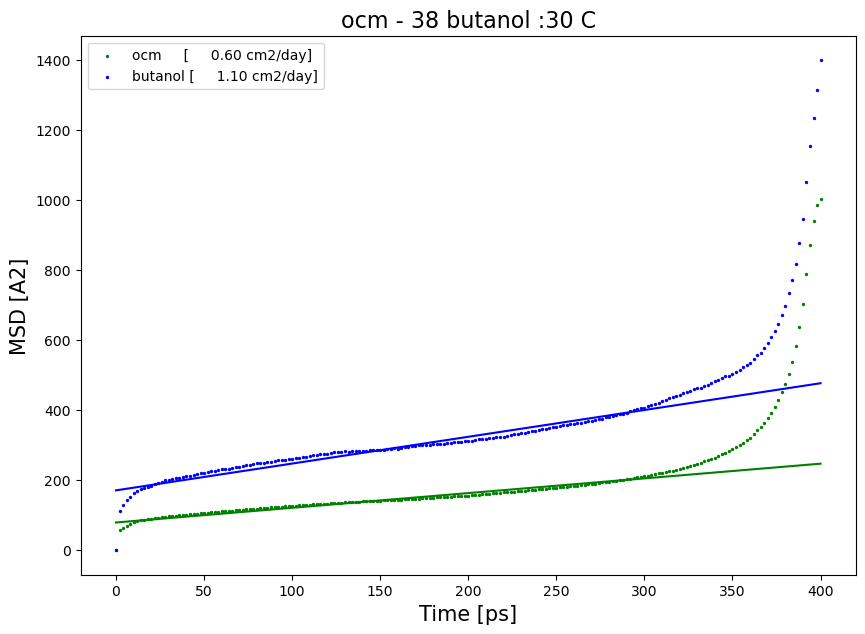

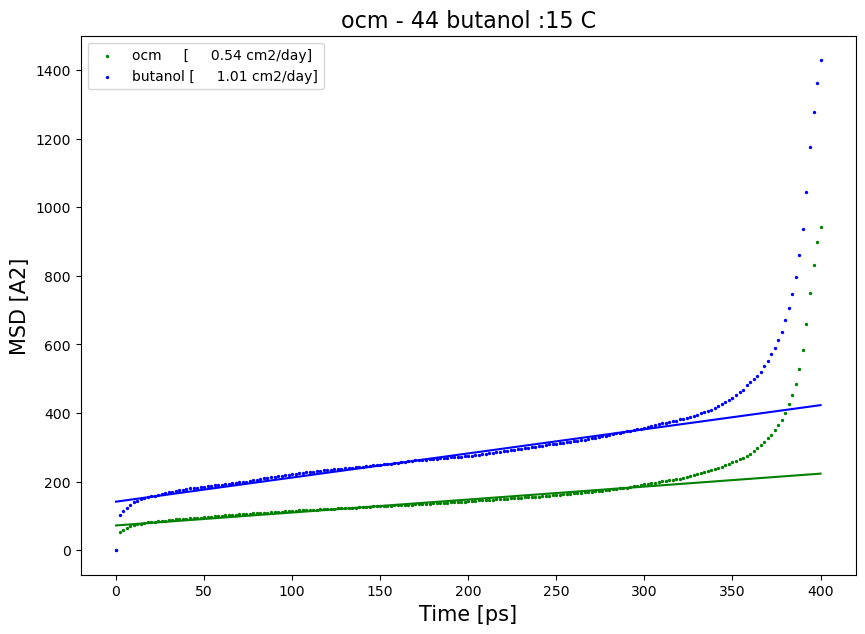

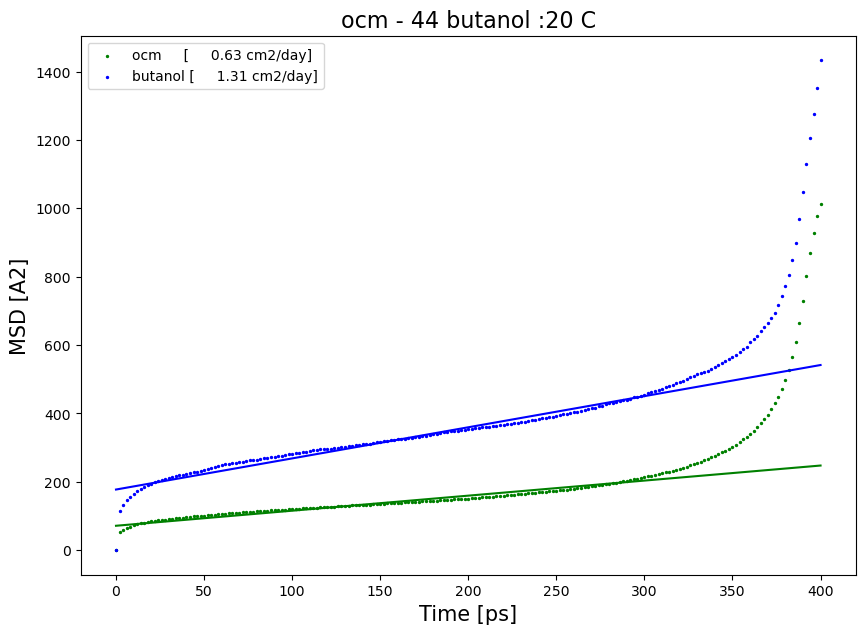

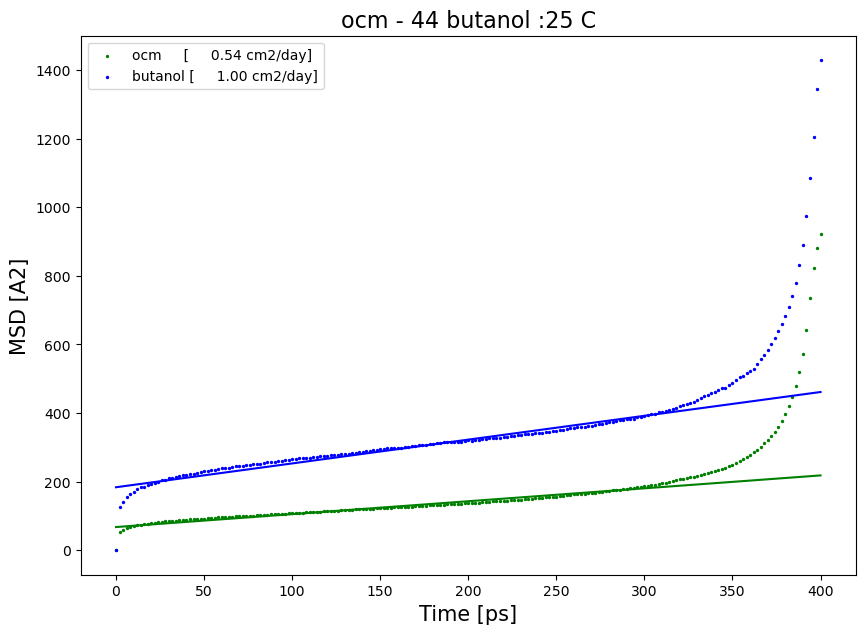

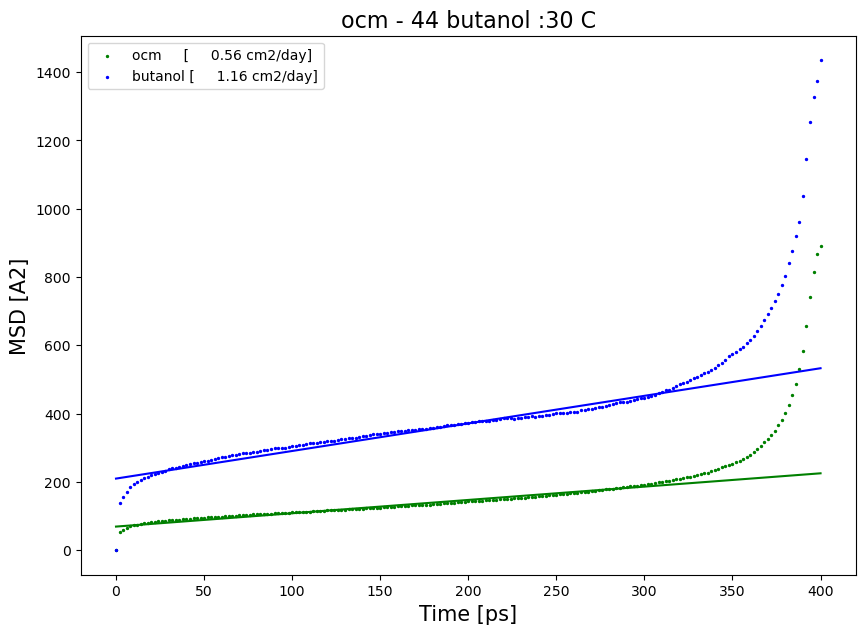

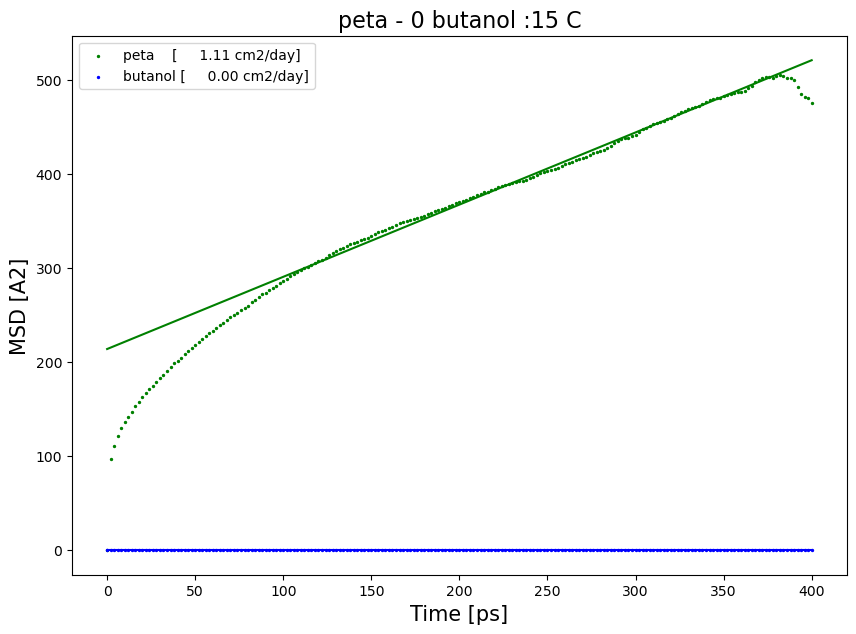

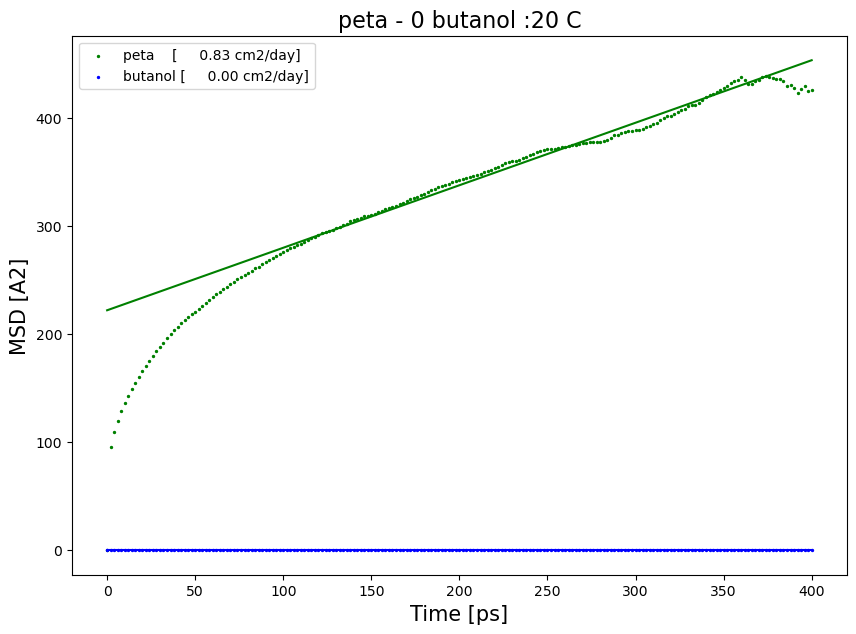

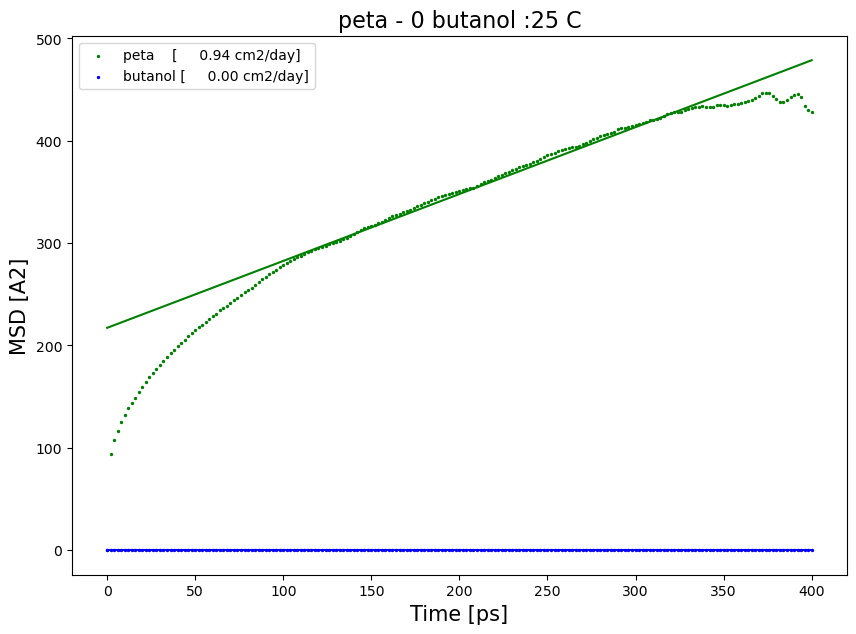

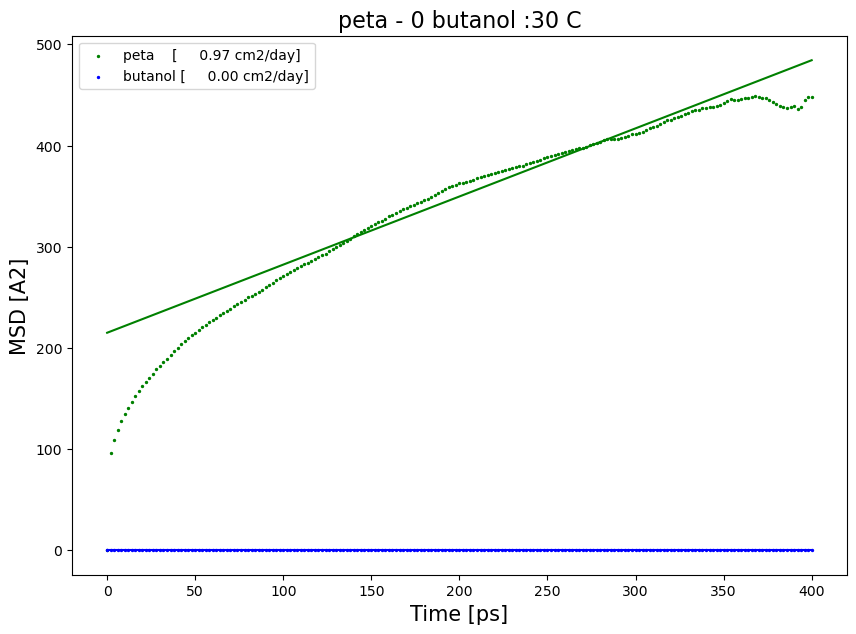

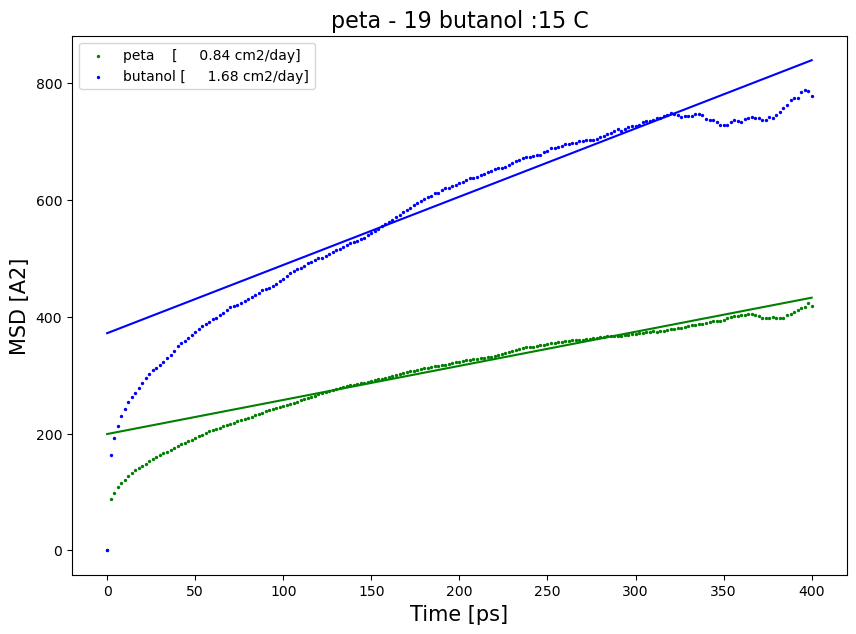

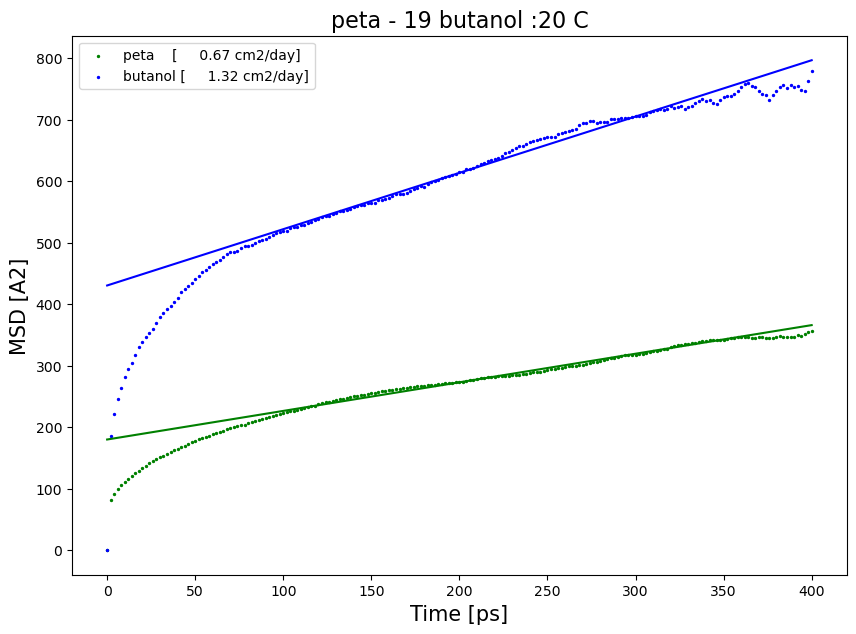

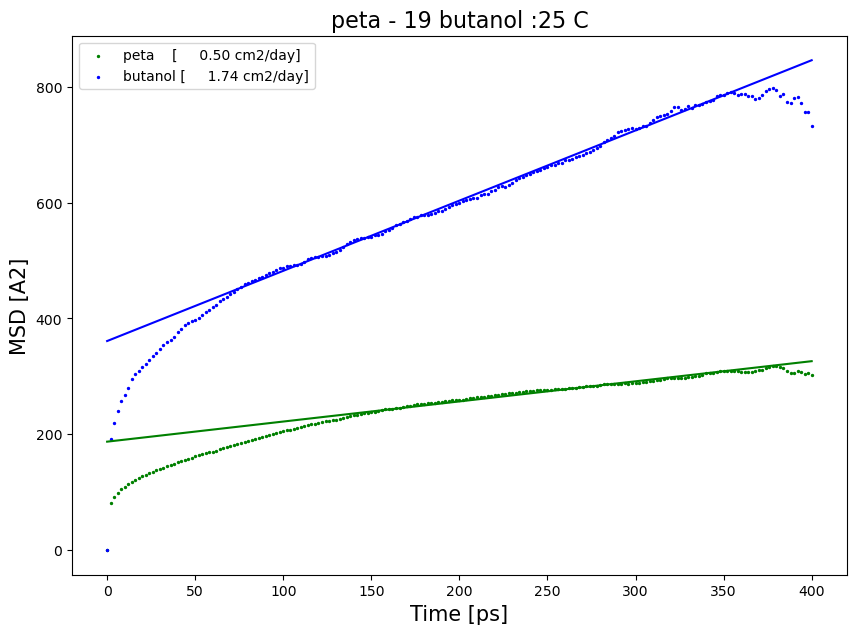

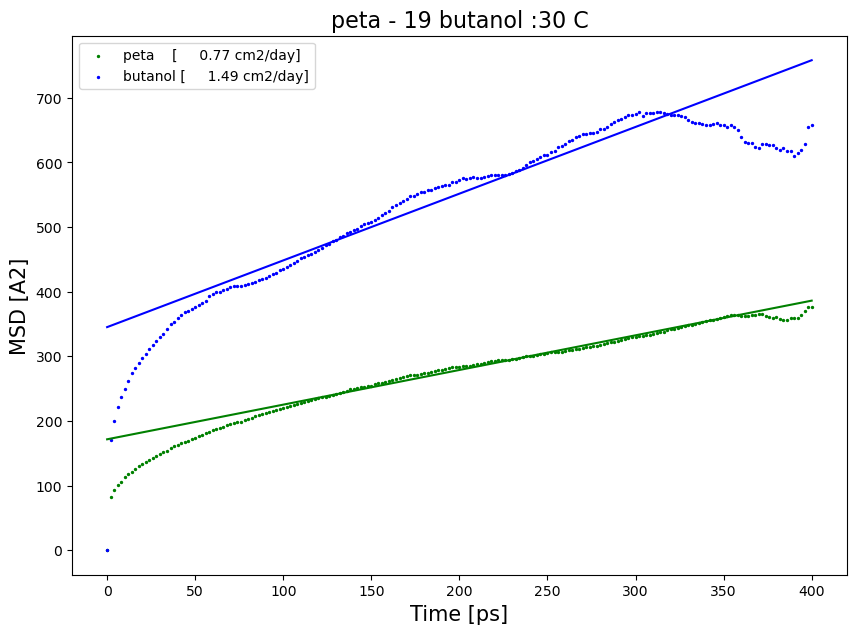

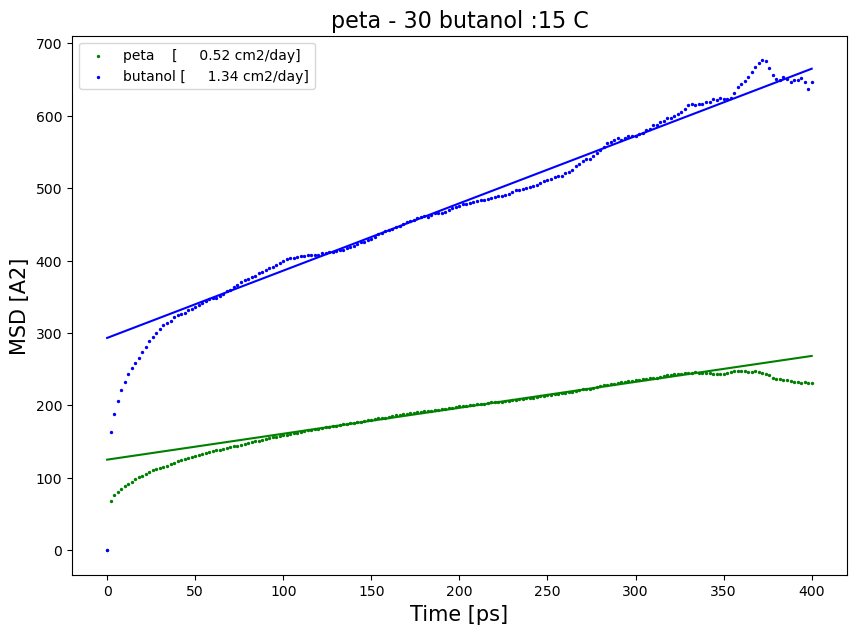

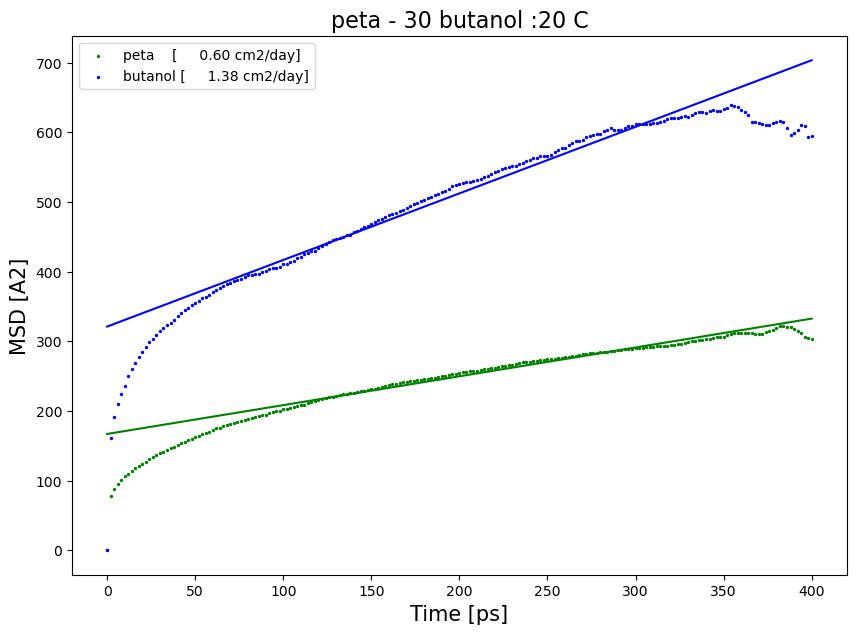

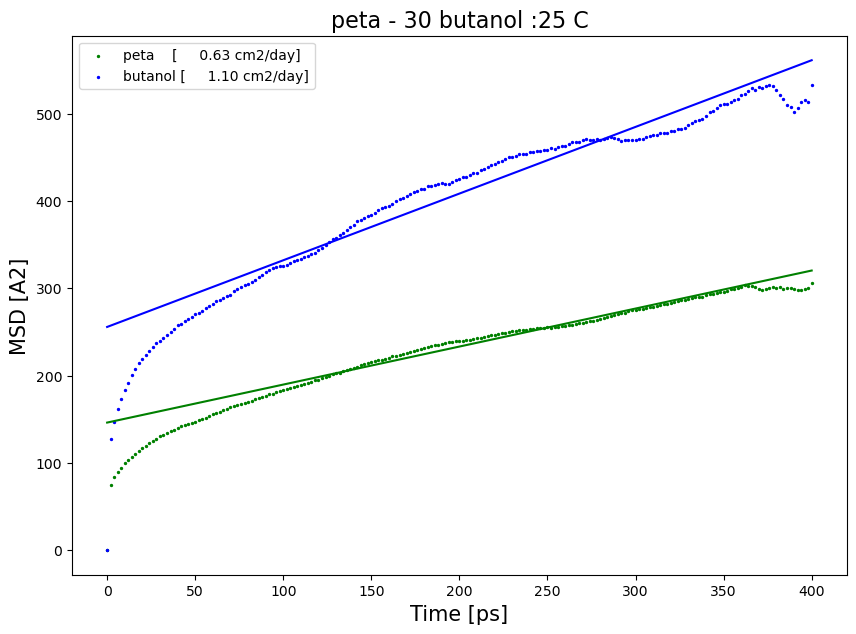

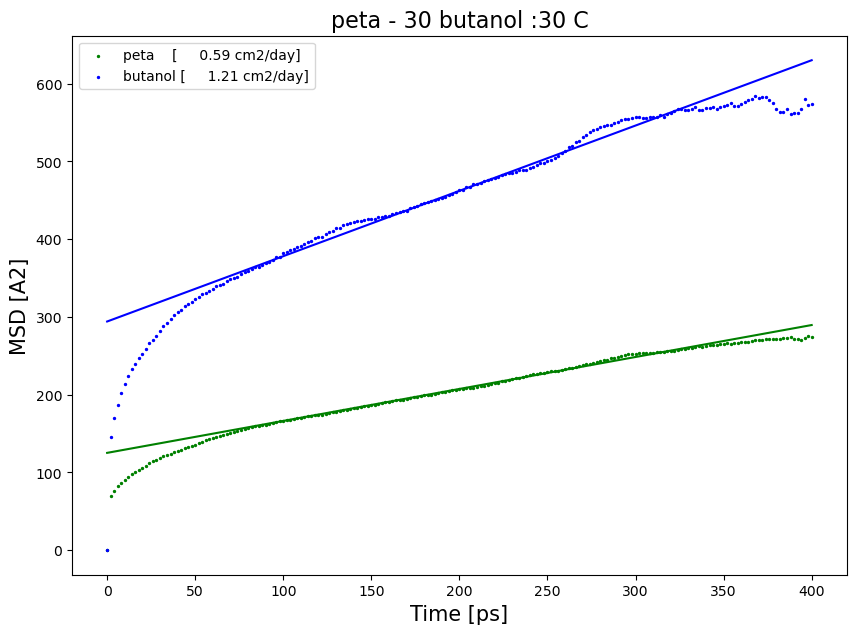

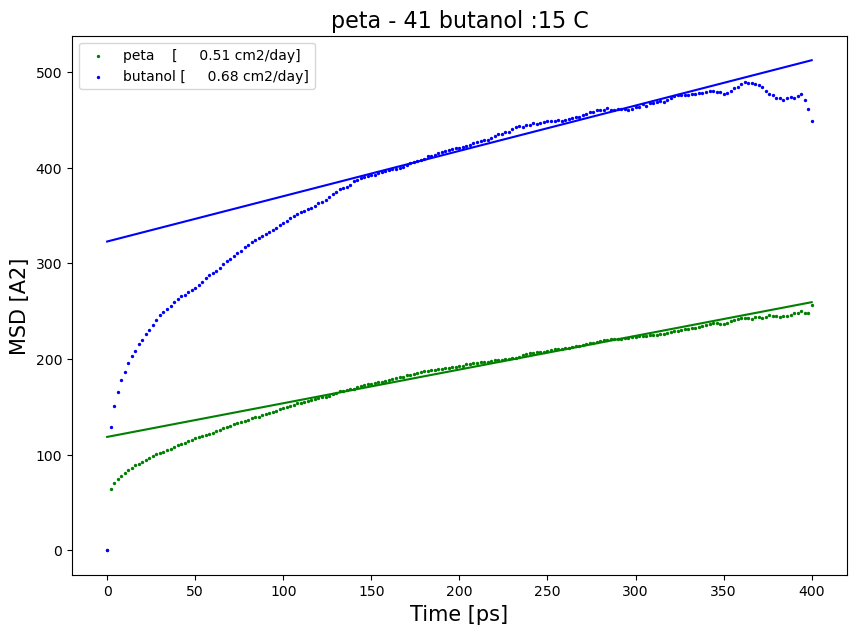

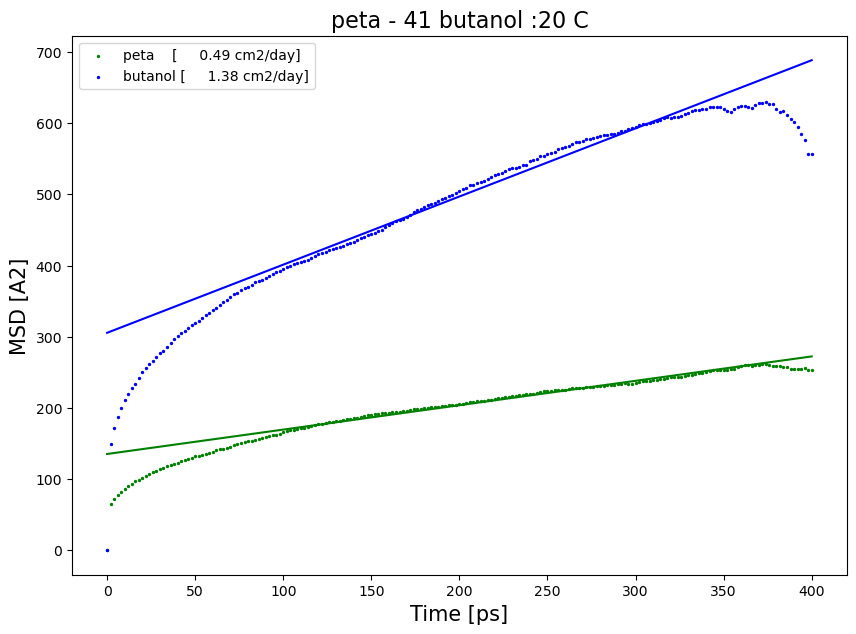

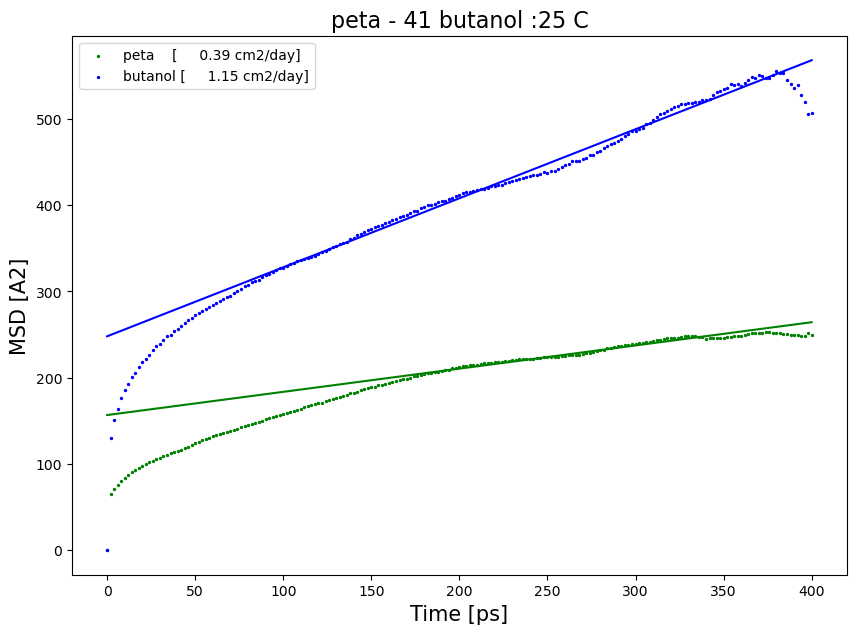

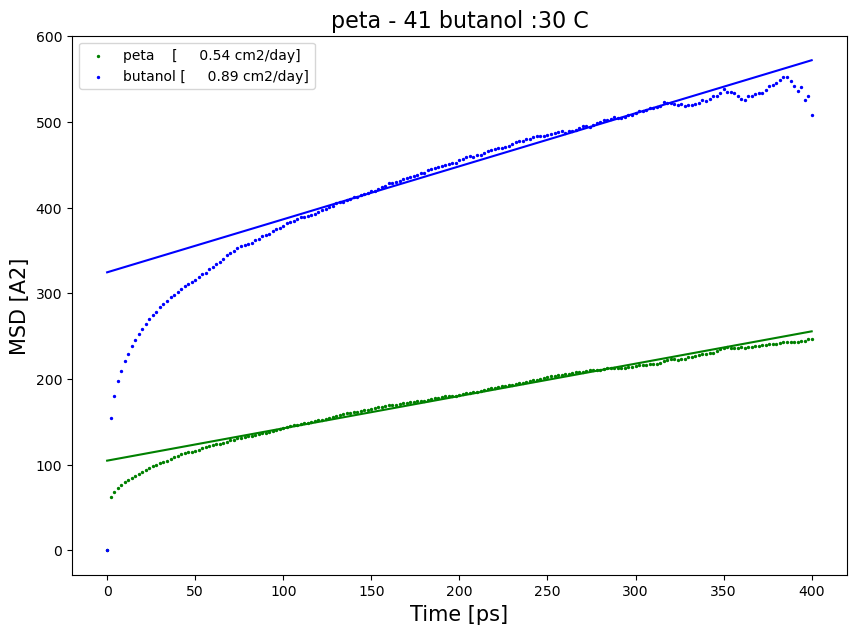

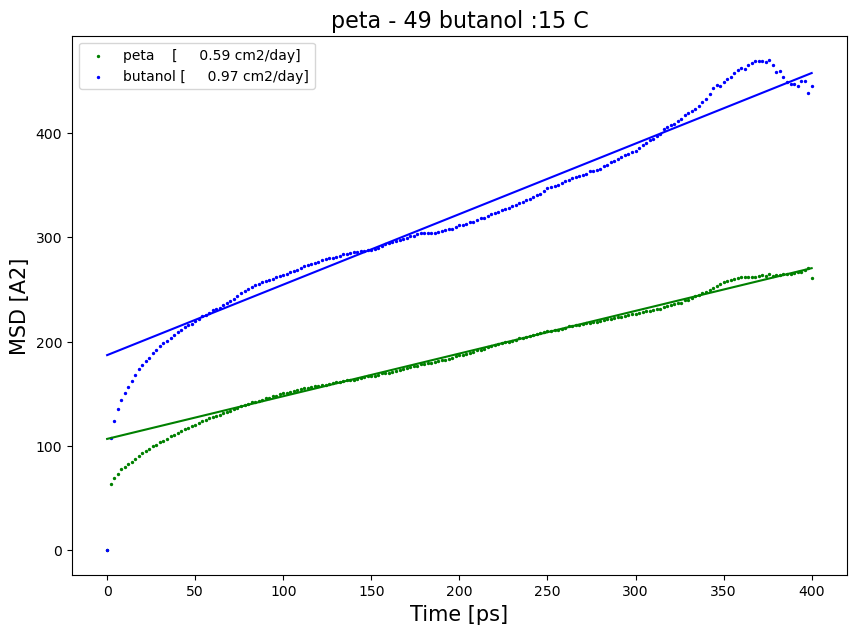

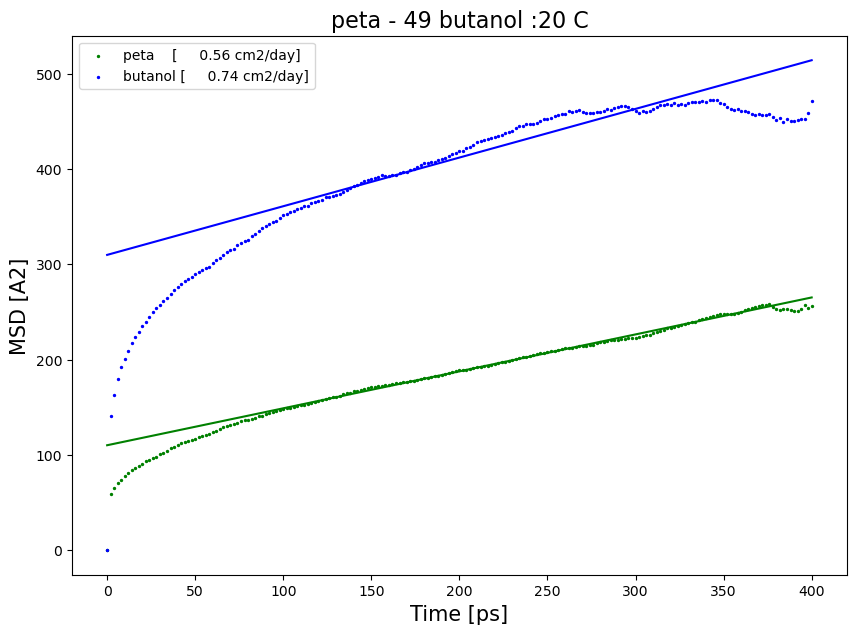

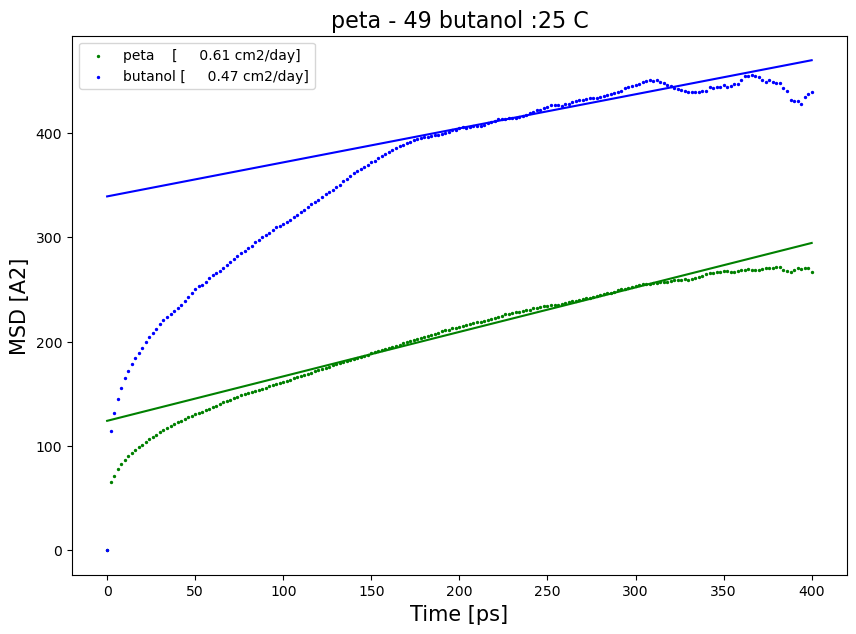

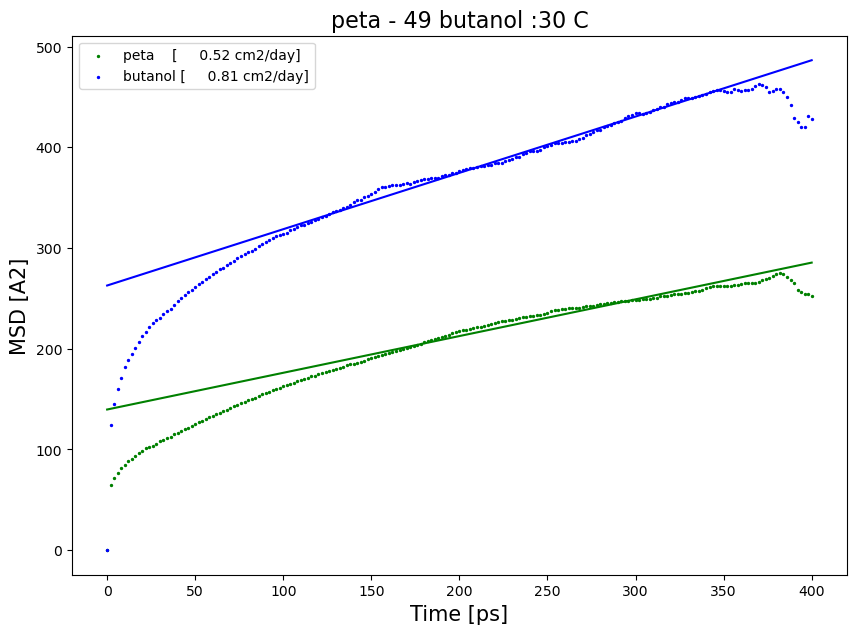

In [9]:
datas = []
for directory in get_solve_dir(solves_path):
    compound, x, rho = directory.parent.stem.split('_')
    T = directory.stem
    pdb = directory / pdb_name
    traj = directory / traj_name

    u = mda.Universe(pdb, traj)

    x_scaller, y_scaller = 1e12, 1e16
    df = get_MSD(u, Mols[compound])
    S, S0 = regress(strict(df))
    D = S / 6 * 24 * 60 * 60

    df_but = get_MSD(u, Mols.butanol)
    S_but, S0_but = regress(strict(df_but))
    D_but = S_but / 6 * 24 * 60 * 60

    fig, ax = plt.subplots()
    ax.set_ylabel('MSD [A2]')
    ax.set_xlabel('Time [ps]')

    time = df['Time']

    ax.scatter(
        time * x_scaller,
        df.iloc[:, 1] * y_scaller,
        label=f'{compound:7} [{D: 9.2f} cm2/day]',
        c='g',
        s=2,
    )

    time_but = df_but['Time']
    ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
    ax.scatter(
        time_but * x_scaller,
        df_but.iloc[:, 1] * y_scaller,
        label=f'butanol [{D_but: 9.2f} cm2/day]',
        c='b',
        s=2,
    )
    ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
    ax.legend()

    ax.set_title(f"{compound} - {x} butanol :{T} C")
    datas.append(
        {
            'compound': compound,
            'x': int(x),
            'Temperature': int(T),
            'D_comp': D,
            'D_but': D_but,
        }
    )

    Path(plots_path).mkdir(parents=True, exist_ok=True)
    fig.savefig(Path(plots_path) / f"{compound}_{x}_{T}.jpg", dpi=600)
    os.remove(traj.parent / f'.{traj.stem}.xtc_offsets.lock')
    os.remove(traj.parent / f'.{traj.stem}.xtc_offsets.npz')

D_df = pd.DataFrame(datas)
D_df.to_csv(Path(plots_path).parent / 'res.csv')

gmx msd \
-mol \
-f traj.xtc \
-s box.gro 


# D analyse

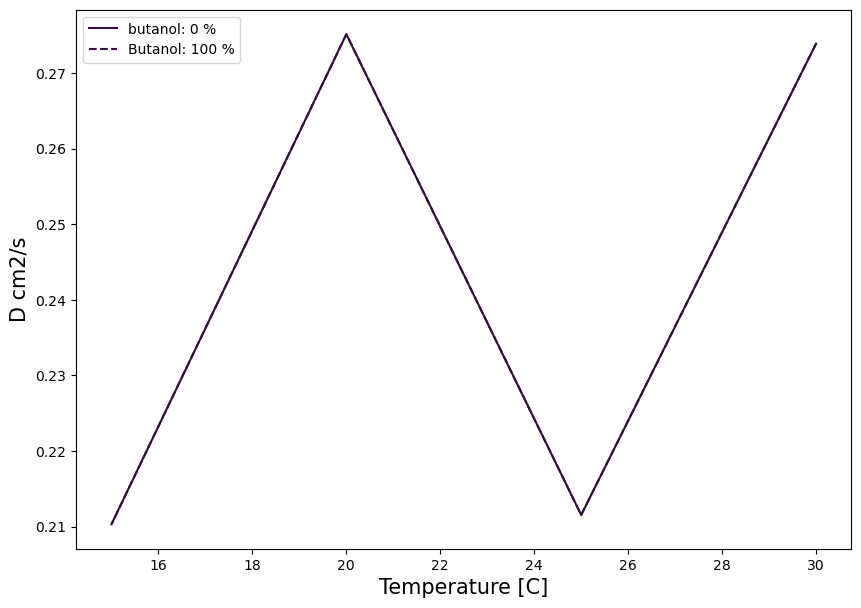

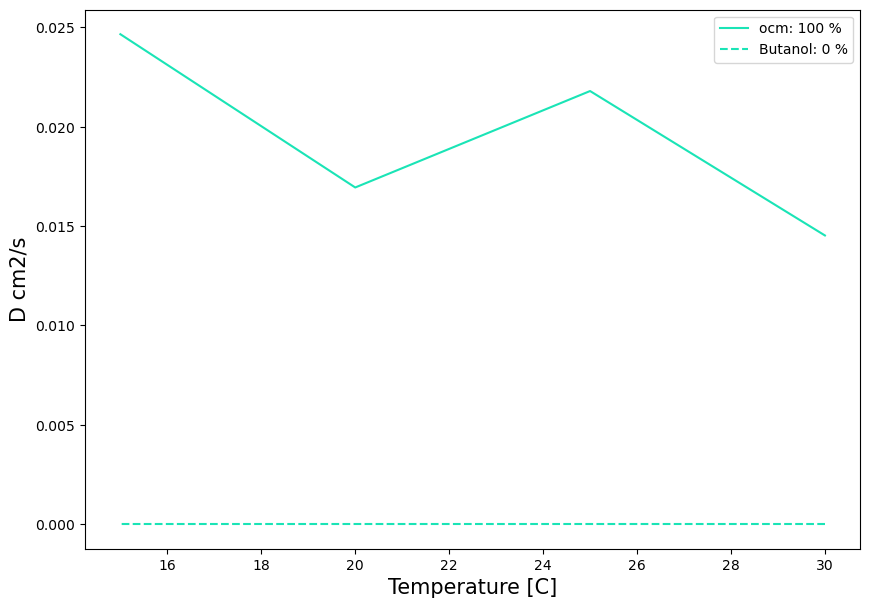

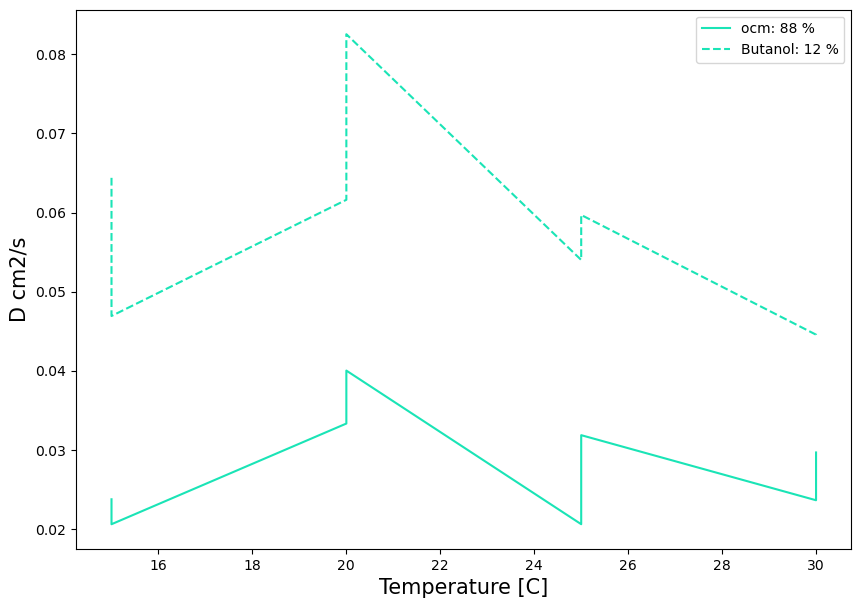

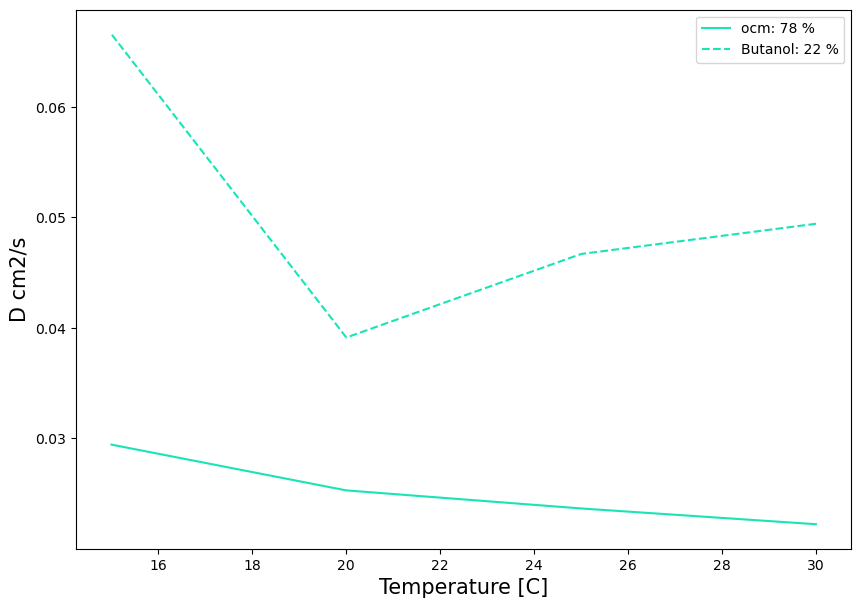

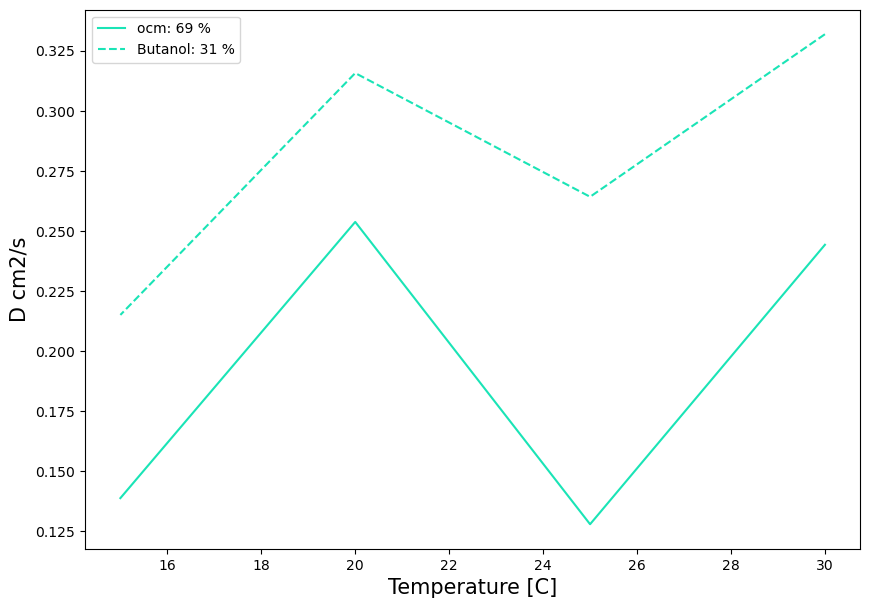

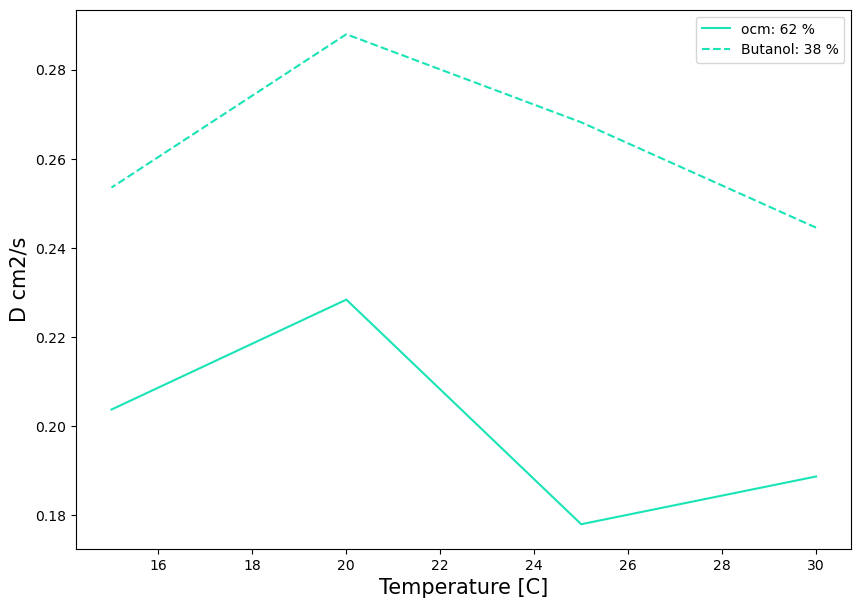

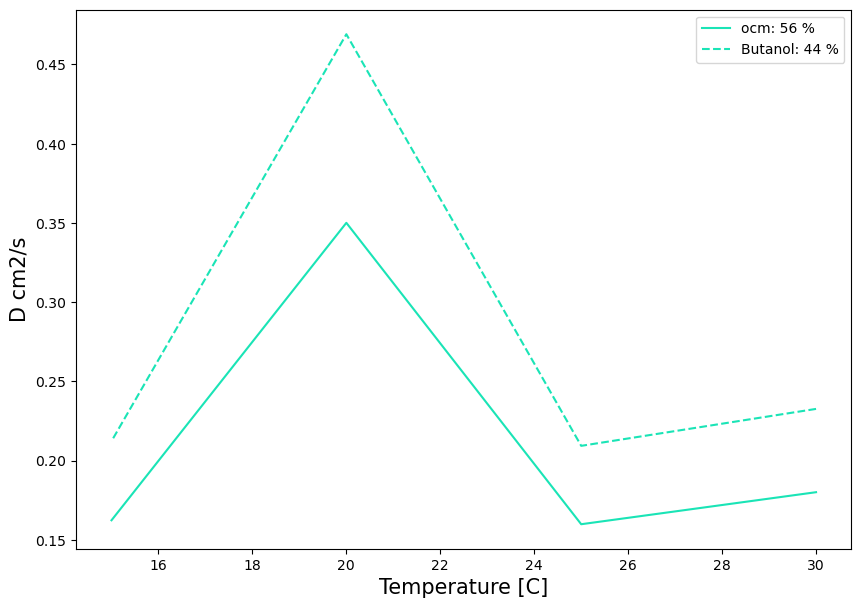

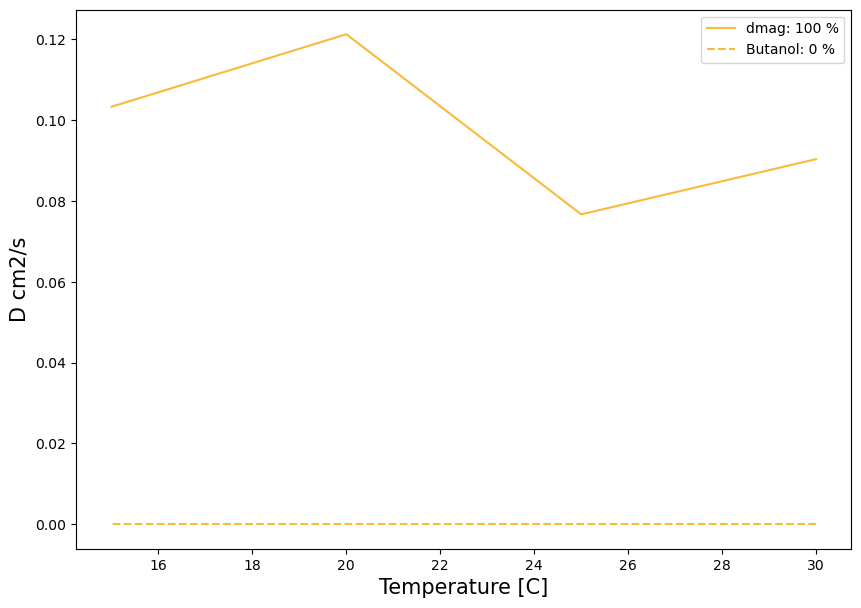

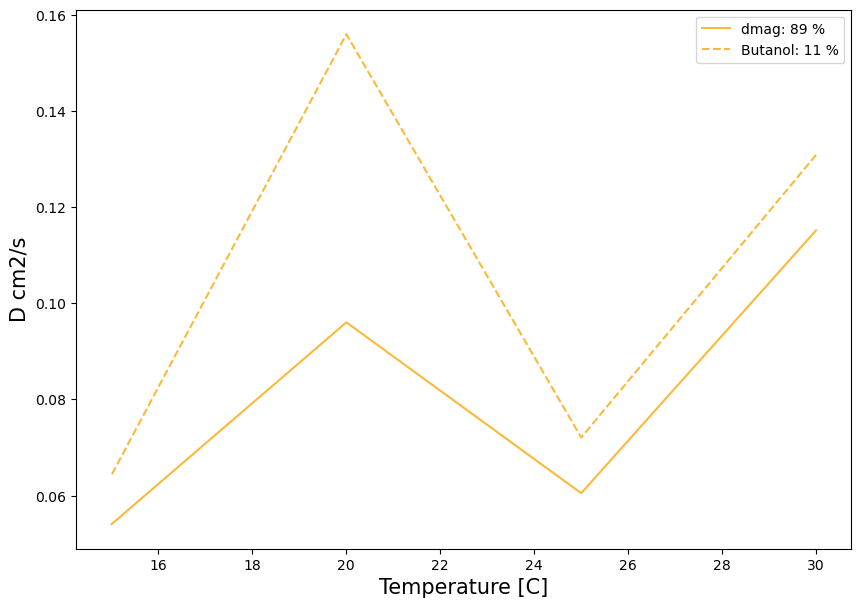

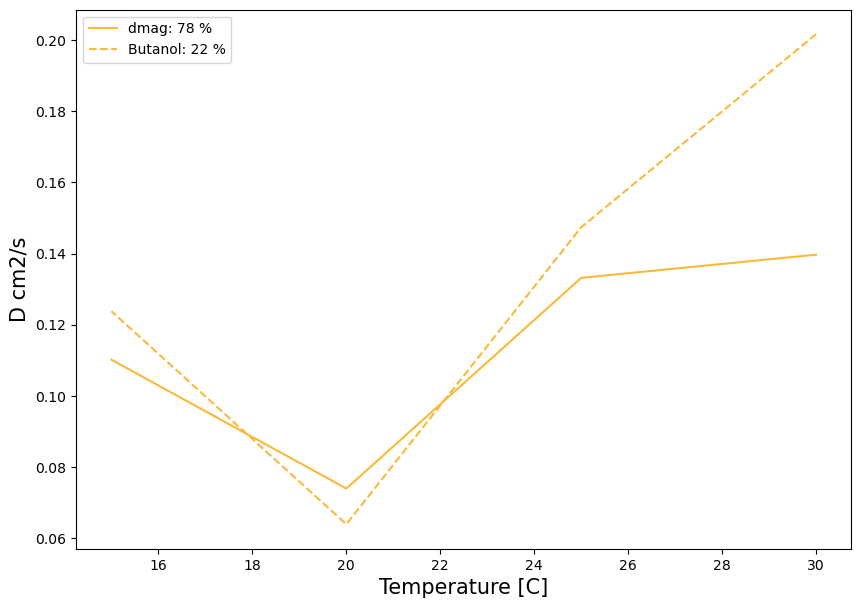

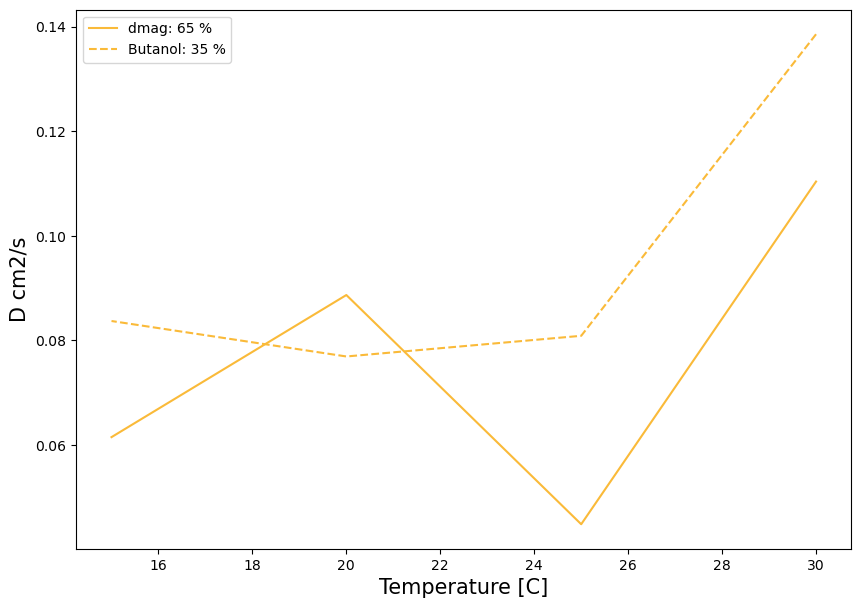

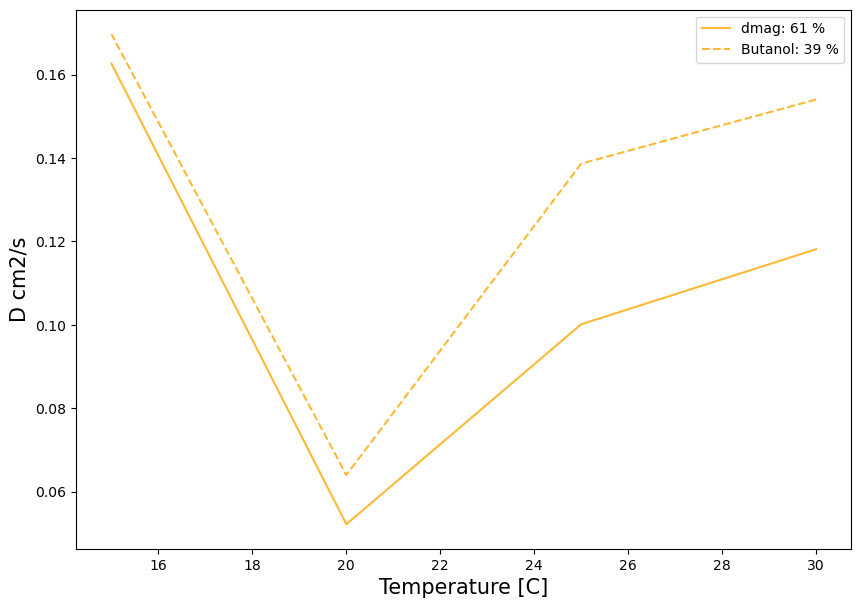

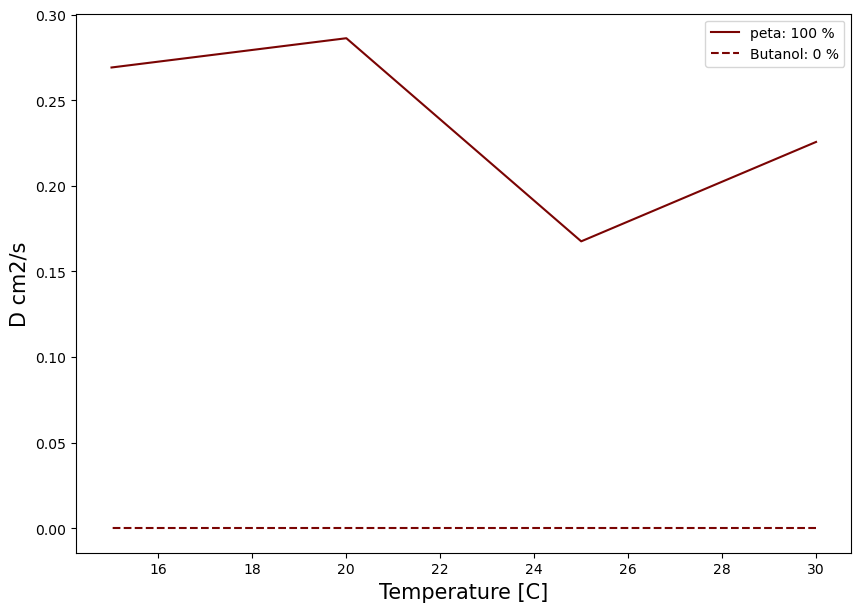

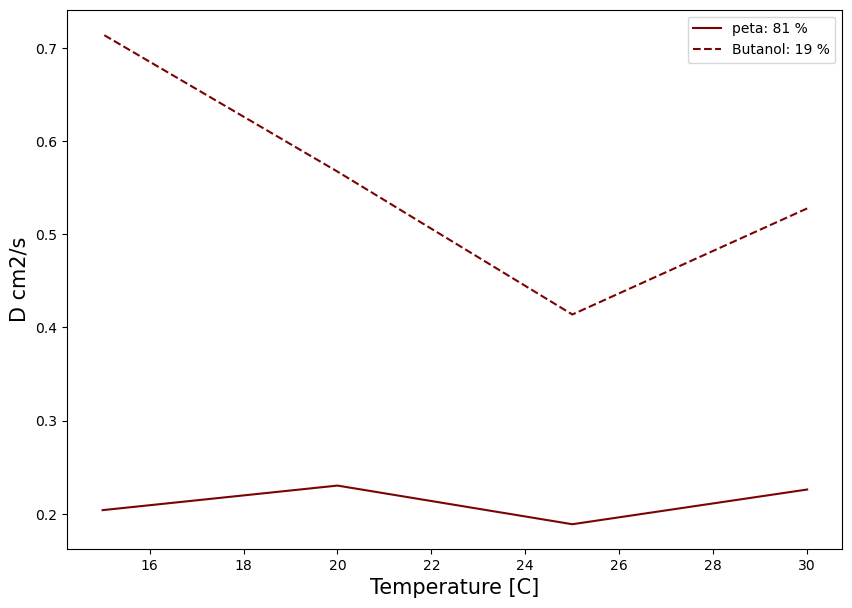

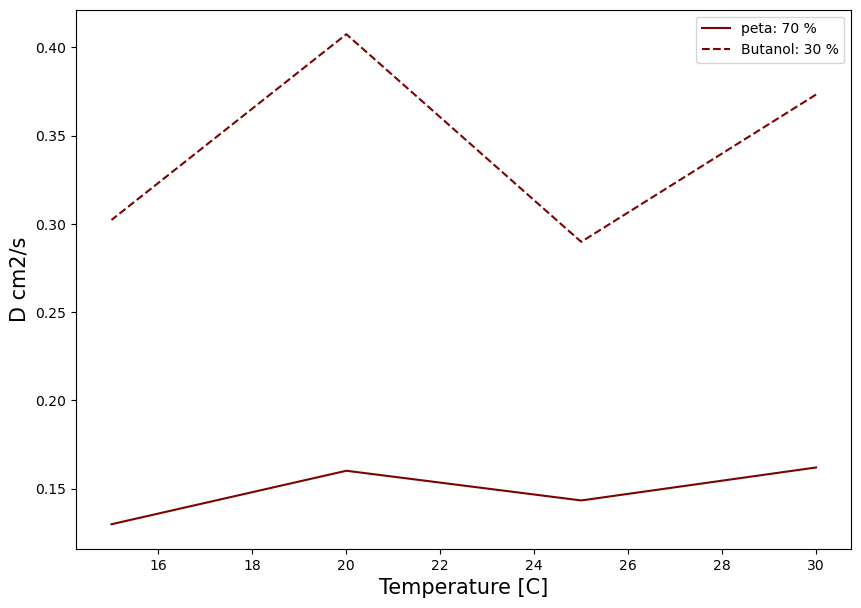

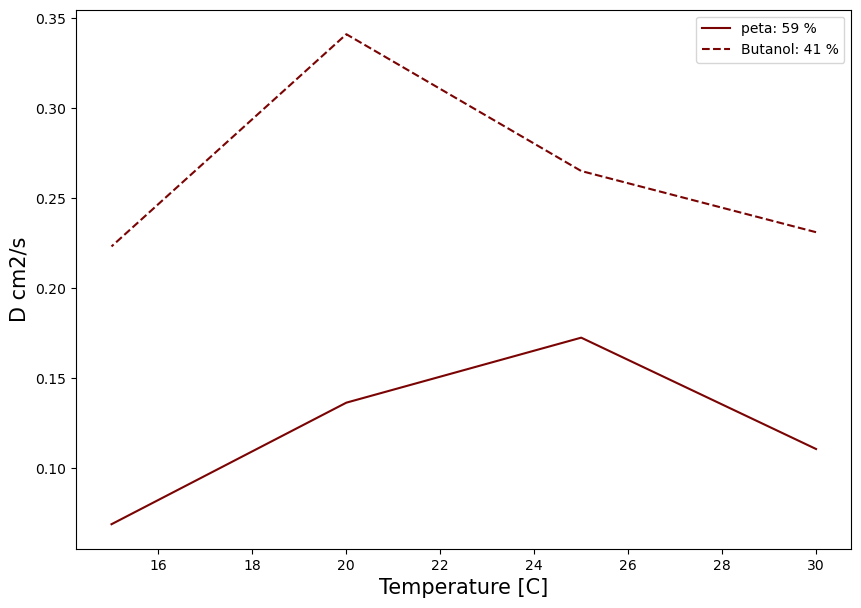

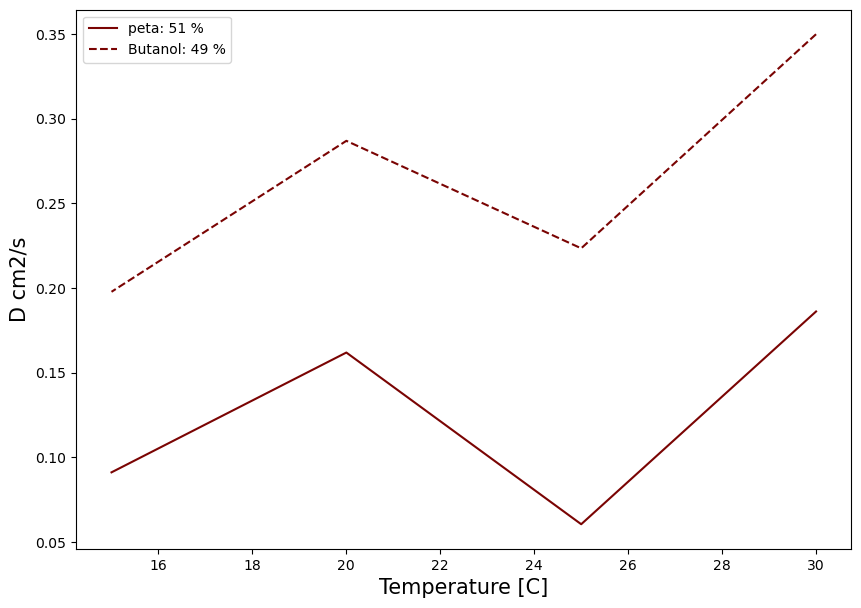

In [207]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D_df['compound'].unique()),
)
i = 0
for compound in Mols:
    df_sub = D_df[D_df['compound'] == compound.name]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['Temperature'], ascending=False)
        ax.plot(
            data_x['Temperature'],
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['Temperature'],
            data_x['D_but'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()
    i += 1

# Combine results

In [51]:
D = pd.read_csv(r'gromacs\workspace\res.csv', index_col=0)
V = pd.read_csv(r'vixcosity\results.csv', index_col=0)[
    ['x', 'Temperature', 'rho', 'w_mass', 'w_vol', 'Viscosity', 'compound']
]
V['x'] = V['x'].astype(int)

In [55]:
M=pd.merge(D,V,on=['x','Temperature','compound'],how='inner')


In [56]:
M = M[M['Temperature']!=20]

In [57]:
M

compound    x  Temperature    D_comp     D_but   rho  w_mass       w_vol  \
0   butanol  100           15  0.210322  0.210322  0.70  100.00  100.000000   
2   butanol  100           25  0.211547  0.211547  0.70  100.00  100.000000   
3   butanol  100           30  0.273862  0.273862  0.70  100.00  100.000000   
4      dmag    0           15  0.103320  0.000000  1.07    0.00    0.000000   
6      dmag    0           25  0.076691  0.000000  1.07    0.00    0.000000   
7      dmag    0           30  0.090354  0.000000  1.07    0.00    0.000000   
8      dmag   11           15  0.054026  0.064249  1.07    4.85    7.413571   
10     dmag   11           25  0.060479  0.072061  1.07    4.85    7.413571   
11     dmag   11           30  0.115183  0.130889  1.07    4.85    7.413571   
12     dmag   22           15  0.110158  0.123768  1.05    9.73   14.595000   
14     dmag   22           25  0.133157  0.147385  1.05    9.73   14.595000   
15     dmag   22           30  0.139675  0.201622  1.05    9.73   14.595000   
16     dmag   35           15  0.061503  0.083702  1.03   16.81   24.734714   
18     dmag   35           25  0.044855  0.080874  1.03   16.81   24.734714   
19     dmag   35           30  0.110364  0.138528  1.03   16.81   24.734714   
21     dmag   39           25  0.100113  0.138625  1.02   19.82   28.880571   
22     dmag   39           30  0.118095  0.154004  1.02   19.82   28.880571   
23      ocm    0           15  0.024655  0.000000  1.72    0.00    0.000000   
25      ocm    0           25  0.021797  0.000000  1.72    0.00    0.000000   
26      ocm    0           30  0.014530  0.000000  1.72    0.00    0.000000   
27      ocm   12           15  0.020582  0.046913  1.58    2.39    5.394571   
28      ocm   12           15  0.023737  0.064388  1.58    2.39    5.394571   
31      ocm   12           25  0.031844  0.059691  1.58    2.39    5.394571   
32      ocm   12           25  0.020585  0.054001  1.58    2.39    5.394571   
33      ocm   12           30  0.029658  0.044541  1.58    2.39    5.394571   
34      ocm   12           30  0.023614  0.044552  1.58    2.39    5.394571   
35      ocm   22           15  0.029425  0.066581  1.57    4.98   11.169429   
37      ocm   22           25  0.023647  0.046688  1.57    4.98   11.169429   
38      ocm   22           30  0.022220  0.049422  1.57    4.98   11.169429   
39      ocm   31           15  0.138840  0.215057  1.55    7.60   16.828571   
41      ocm   31           25  0.127981  0.264210  1.55    7.60   16.828571   
42      ocm   31           30  0.244249  0.331848  1.55    7.60   16.828571   
43      ocm   38           15  0.203746  0.253550  1.54   10.07   22.154000   
45      ocm   38           25  0.178013  0.268195  1.54   10.07   22.154000   
46      ocm   38           30  0.188723  0.244557  1.54   10.07   22.154000   
47      ocm   44           15  0.162420  0.212346  1.53   12.30   26.884286   
49      ocm   44           25  0.159932  0.209390  1.53   12.30   26.884286   
50      ocm   44           30  0.180137  0.232690  1.53   12.30   26.884286   
51     peta    0           25  0.167569  0.000000  1.20    0.00    0.000000   
52     peta    0           30  0.225625  0.000000  1.20    0.00    0.000000   
53     peta   19           15  0.203917  0.714847  1.18    5.80    9.777143   
55     peta   19           25  0.188796  0.413948  1.18    5.80    9.777143   
56     peta   19           30  0.226054  0.527840  1.18    5.80    9.777143   
57     peta   30           15  0.129853  0.302195  1.16    9.75   16.157143   
59     peta   30           25  0.143319  0.289779  1.16    9.75   16.157143   
60     peta   30           30  0.161994  0.373214  1.16    9.75   16.157143   
61     peta   41           15  0.069012  0.223315  1.14   14.90   24.265714   
63     peta   41           25  0.172650  0.265224  1.14   14.90   24.265714   
64     peta   41           30  0.110798  0.231232  1.14   14.90   24.265714   
65     peta   49           15  0.091170  0.197736  1.

In [46]:
def calculate_h_comp(r: pd.Series):
    T = r['Temperature']+273
    v = r['Viscosity']
    D_comp = r['D_comp']
    return T / (v * D_comp)


def calculate_h_but(r: pd.Series):
    T = r['Temperature']+273
    v = r['Viscosity']
    D_but = r['D_but']
    return T / (v * D_but) if D_but else 0

M['H_comp']= M.apply(calculate_h_comp,axis=1)
M['H_but']= M.apply(calculate_h_but,axis=1)

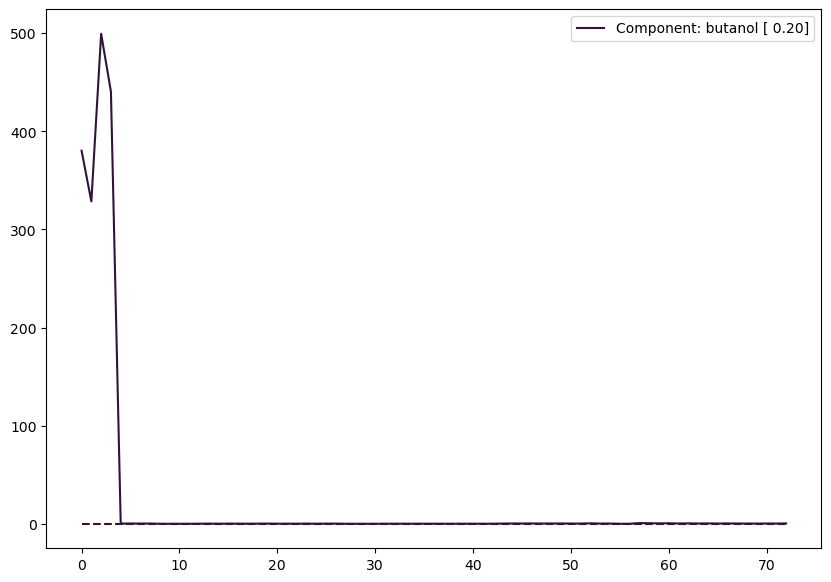

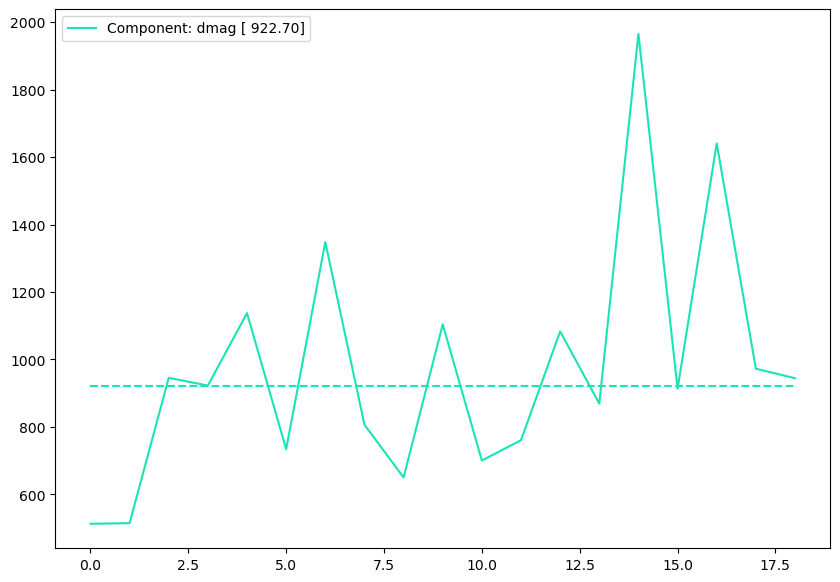

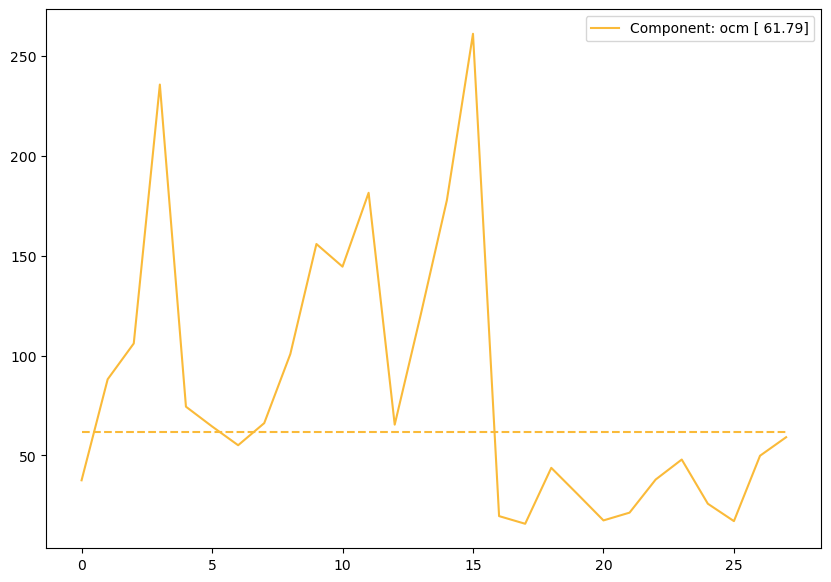

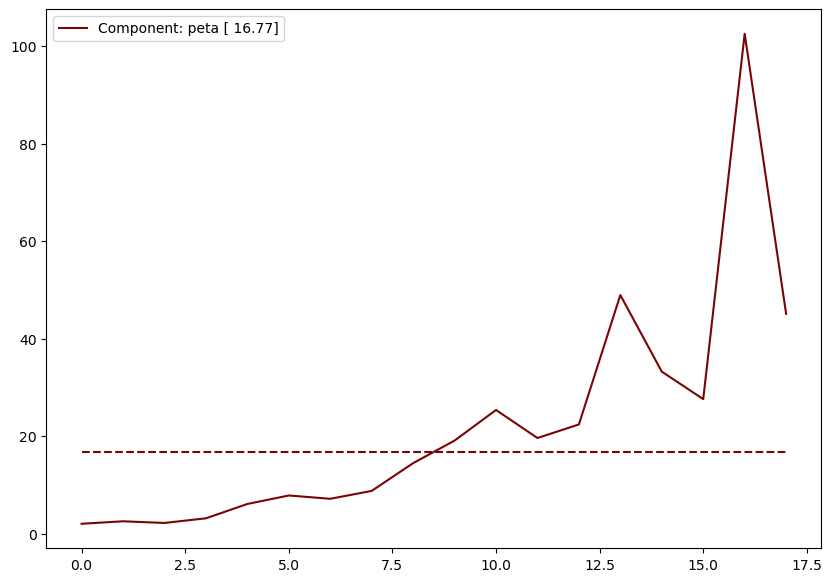

In [48]:
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(M['compound'].unique()),
)
i = 0
d_dict = {}
for name, group in M.groupby(by='compound'):
    H_comp = np.array(group['H_comp'])
    if name == 'butanol':
        H_but = np.array(M['D_but'])
        H_comp = np.array([*H_comp, *H_but])[:]

    H0 = np.median(H_comp)
    d_dict[name] = H0
    fig, ax = plt.subplots(num="H")
    ax.plot(
        H_comp,
        c=colors_list[i],
        label=f"Component: {name} [{H0: .2f}]",
    )
    ax.plot(
        [H0] * len(H_comp),
        c=colors_list[i],
        linestyle='dashed',
    )
    ax.legend()
    plt.show()
    i += 1

In [40]:
d_dict

{'butanol': 0.15069447094171534,
 'dmag': 75.35637065465117,
 'ocm': 4.0263121776834545,
 'peta': 1.2666302904165525}

In [42]:
def calculate_D(r):
    v = r['Viscosity']
    T = r['Temperature']+273
    comp = r['compound']
    h = d_dict[comp]
    return T / v / h


def calculate_D_but(r):
    v = r['Viscosity']
    T = r['Temperature']+273
    h = d_dict['butanol']
    return T / v / h

M['D_comp0']=M['D_comp']
M['D_comp'] = M.apply(calculate_D, axis=1)
M['D_but0']=M['D_but']
M['D_but'] = M.apply(calculate_D_but, axis=1)
M